# Train Log 20181129

## Results
```

```

## Trained model
* [Download link]()

## Evaluation
* Incorrect sample
![results]()

In [2]:
import os, sys
import numpy as np
import matplotlib.pyplot as plt
import time , datetime

sys.path.append( os.path.abspath('../../../Dataset/scripts'))
from utils import *

sys.path.append( os.path.abspath('../../model') )
from train import *
import model_opt5 as MODEL

In [3]:
""" Path """
data_train_path = os.path.abspath('../../../Dataset_ver2/dataset/db_v8_aug_20181129_ndb_v2_20181020/train.h5')
data_vali_path = os.path.abspath('../../../Dataset_ver2/dataset/db_v8_aug_20181129_ndb_v2_20181020/vali.h5')


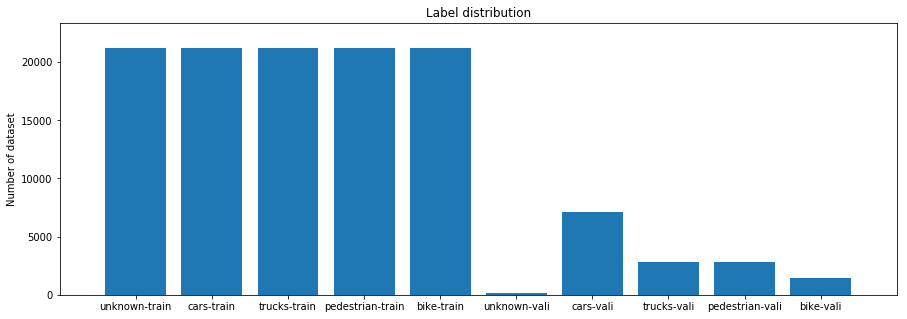

In [4]:
""" Load dataset"""

data = []
label = []

data_train, label_train = load_h5(data_train_path)
data_vali, label_vali = load_h5(data_vali_path)

data.append(data_train)
data.append(data_vali)
label.append(label_train)
label.append(label_vali)

""" Data statistics """

label_list = [0,1,2,3,4]

y_val = []
for i in range( len ( data) ):
    for j in range ( len ( label_list ) ):
        y_val.append(np.sum(label[i] == label_list[j]))

x_name=('unknown-train', 'cars-train', 'trucks-train', 'pedestrian-train', 'bike-train',
        'unknown-vali', 'cars-vali', 'trucks-vali', 'pedestrian-vali', 'bike-vali')

index = range( len(x_name) )

plt.figure(figsize=(15,5))
plt.bar(index, y_val, tick_label=x_name, align='center')
plt.ylabel('Number of dataset')
plt.title('Label distribution')
plt.xlim( -1, len(x_name))
plt.ylim( 0, np.max(y_val) * 1.1 )
plt.show()

In [6]:
""" Path """
log_path = os.path.abspath('./train_log_20181129.txt')

model_save_path = os.path.abspath('./model')
if not os.path.isdir(model_save_path) : os.mkdir(model_save_path)

""" Parameters """
GPU_INDEX = 0
NUM_POINT = 1024
NUM_CLASSES = 5

BN_INIT_DECAY = 0.5
BN_DECAY_DECAY_RATE = 0.5
BN_DECAY_DECAY_STEP = float(200000)
BN_DECAY_CLIP = 0.99
DECAY_STEP = BN_DECAY_DECAY_STEP
DECAY_RATE = BN_DECAY_DECAY_RATE

BATCH_SIZE = 250

MOMENTUM = 0.9

BASE_LEARNING_RATE = 0.001

OPTIMIZER = 'adam'

MAX_EPOCH = 50

""" log file """
LOG_FOUT = open(log_path, 'w')

def log_string(out_str):
    out_str = str( datetime.datetime.fromtimestamp( time.time() ) ) + "  " + out_str
    LOG_FOUT.write(out_str+'\n')
    LOG_FOUT.flush()
    print(out_str)
    
    
def get_learning_rate(batch):
    learning_rate = tf.train.exponential_decay(
                        BASE_LEARNING_RATE,  # Base learning rate.
                        batch * BATCH_SIZE,  # Current index into the dataset.
                        DECAY_STEP,          # Decay step.
                        DECAY_RATE,          # Decay rate.
                        staircase=True)
    learning_rate = tf.maximum(learning_rate, 0.00001) # CLIP THE LEARNING RATE!
    return learning_rate        

def get_bn_decay(batch):
    bn_momentum = tf.train.exponential_decay(
                      BN_INIT_DECAY,
                      batch * BATCH_SIZE,
                      BN_DECAY_DECAY_STEP,
                      BN_DECAY_DECAY_RATE,
                      staircase=True)
    bn_decay = tf.minimum(BN_DECAY_CLIP, 1 - bn_momentum)
    return bn_decay

""" load traing model """
with tf.Graph().as_default():
    with tf.device('/gpu:'+str(GPU_INDEX)):
        pointclouds_pl, labels_pl = MODEL.placeholder_inputs(BATCH_SIZE, NUM_POINT)
        is_training_pl = tf.placeholder(tf.bool, shape=())
        print(is_training_pl)

        # Note the global_step=batch parameter to minimize. 
        # That tells the optimizer to helpfully increment the 'batch' parameter for you every time it trains.
        batch = tf.Variable(0)
        bn_decay = get_bn_decay(batch)
        tf.summary.scalar('bn_decay', bn_decay)

        # Get model and loss 
        pred, end_points = MODEL.get_model(pointclouds_pl, is_training_pl, bn_decay=bn_decay)
        loss = MODEL.get_loss(pred, labels_pl, end_points)
        tf.summary.scalar('loss', loss)

        correct = tf.equal(tf.argmax(pred, 1), tf.to_int64(labels_pl))
        accuracy = tf.reduce_sum(tf.cast(correct, tf.float32)) / float(BATCH_SIZE)
        tf.summary.scalar('accuracy', accuracy)

        # Get training operator
        learning_rate = get_learning_rate(batch)
        tf.summary.scalar('learning_rate', learning_rate)
        if OPTIMIZER == 'momentum':
            optimizer = tf.train.MomentumOptimizer(learning_rate, momentum=MOMENTUM)
        elif OPTIMIZER == 'adam':
            optimizer = tf.train.AdamOptimizer(learning_rate)
        train_op = optimizer.minimize(loss, global_step=batch)

        # Add ops to save and restore all the variables.
        saver = tf.train.Saver()

    # Create a session
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    config.allow_soft_placement = True
    config.log_device_placement = False
    sess = tf.Session(config=config)

    # Add summary writers
    #merged = tf.merge_all_summaries()
    merged = tf.summary.merge_all()

    train_writer_path = os.path.abspath( os.path.join(model_save_path, 'train') )
    if os.path.isdir(train_writer_path): os.system('rm -r {}'.format(train_writer_path))
    os.mkdir(train_writer_path)
        
    test_writer_path = os.path.abspath( os.path.join(model_save_path, 'test') )
    if os.path.isdir(test_writer_path): os.system('rm -r {}'.format(test_writer_path))
    os.mkdir(test_writer_path)
    
    
    train_writer = tf.summary.FileWriter(train_writer_path, sess.graph)
    test_writer = tf.summary.FileWriter(test_writer_path)
    
    
    # Init variables
    init = tf.global_variables_initializer()
    # To fix the bug introduced in TF 0.12.1 as in
    # http://stackoverflow.com/questions/41543774/invalidargumenterror-for-tensor-bool-tensorflow-0-12-1
    #sess.run(init)
    sess.run(init, {is_training_pl: True})

    ops = {'pointclouds_pl': pointclouds_pl,
           'labels_pl': labels_pl,
           'is_training_pl': is_training_pl,
           'pred': pred,
           'loss': loss,
           'train_op': train_op,
           'merged': merged,
           'step': batch}
    
            
    for epoch in range(MAX_EPOCH):
        
        ## Training
        log_string ( " Train one epoch %3d / %3d" % (epoch+1, MAX_EPOCH) )
        sys.stdout.flush()
        
        is_training = True
        
        # Shuffle train files
        train_file_idxs = np.arange(0, data_train.shape[0])
        np.random.shuffle(train_file_idxs)
        
        current_data = data_train[train_file_idxs] 
        current_label = label_train[train_file_idxs]
        current_label.reshape((data_train.shape[0],))
              
        ## Evaluation metric
        total_correct = 0
        total_seen = 0
        loss_sum = 0
        
        total_class = [0 for _ in range(NUM_CLASSES)]
        total_detect_class = [0 for _ in range(NUM_CLASSES)]
        total_correct_class = [0 for _ in range(NUM_CLASSES)]
            
        num_batches = current_data.shape[0] // BATCH_SIZE
               
        for batch_idx in trange(num_batches):
            
            start_idx = batch_idx * BATCH_SIZE
            end_idx = (batch_idx+1) * BATCH_SIZE           

            # Augment batched point clouds by rotation and jittering
            rotated_data = provider.rotate_point_cloud(current_data[start_idx:end_idx, :, :])
            jittered_data = provider.jitter_point_cloud(rotated_data)
            
            feed_dict = {ops['pointclouds_pl']: jittered_data,
                         ops['labels_pl']: current_label[start_idx:end_idx].reshape((BATCH_SIZE,)),
                         ops['is_training_pl']: is_training,}
            
            summary, step, _, loss_val, pred_val = sess.run([ops['merged'], ops['step'],
                ops['train_op'], ops['loss'], ops['pred']], feed_dict=feed_dict)
            
            train_writer.add_summary(summary, step)
            
            pred_val = np.argmax(pred_val, 1)
            correct = np.sum(pred_val == current_label[start_idx:end_idx])
            total_correct += correct
            total_seen += BATCH_SIZE
            loss_sum += loss_val
            
            for i in range(NUM_CLASSES):
                total_class[i] = np.sum( np.ones(BATCH_SIZE) * i == current_label[start_idx:end_idx] )
                total_detect_class[i] = np.sum( np.ones(BATCH_SIZE) * i == pred_val )
                total_correct_class[i] = np.sum( (np.ones(BATCH_SIZE) * i == current_label[start_idx:end_idx]) * \
                                                    (np.ones(BATCH_SIZE) * i == pred_val) )
                                
        log_string(  '[Epoch %d] mean loss: %f' % \
                   (  epoch, loss_sum / float(total_seen)  )   )
        log_string(  '[Epoch %d] accuracy: %f'% \
                   (  epoch, total_correct / float(total_seen)  )   )
        log_string(  '[Epoch %d] avg class acc: %f' % \
                   (  epoch, np.mean( np.array(total_correct_class)/np.array(total_class,dtype=np.float) )  )   )
        
        for i_cls in range(NUM_CLASSES):
            if not float(total_class[i_cls]) == 0:
                log_string(  '[Epoch %d] indivisual [%d] class recall: %f' % \
                       (  epoch, i_cls, float(total_correct_class[i_cls])/float(total_class[i_cls])))    
            if not float(total_detect_class[i_cls]) == 0:
                log_string(  '[Epoch %d] indivisual [%d] class precision: %f' % \
                       (  epoch, i_cls, float(total_correct_class[i_cls])/float(total_detect_class[i_cls])))    


        ## Evaluation using validation set    
        log_string ( " Evaluation one (validation set) epoch %3d / %3d" % (epoch+1, MAX_EPOCH) )
        sys.stdout.flush()
        
        is_training = False
        total_correct = 0
        total_seen = 0
        total_seen_class = [0 for _ in range(NUM_CLASSES)]
        total_correct_class = [0 for _ in range(NUM_CLASSES)]
        total_detect_class = [0 for _ in range(NUM_CLASSES)]
        total_detect_true_class = [0 for _ in range(NUM_CLASSES)]
        
        # Shuffle validation files
        file_idxs = np.arange(0, data_vali.shape[0])
        np.random.shuffle(file_idxs)
        
        current_data = data_vali[file_idxs]
        current_label = label_vali[file_idxs]
        
        num_batches = current_data.shape[0] // BATCH_SIZE
               
        for batch_idx in trange(num_batches):
            start_idx = batch_idx * BATCH_SIZE
            end_idx = (batch_idx+1) * BATCH_SIZE

            feed_dict = {ops['pointclouds_pl']: current_data[start_idx:end_idx, :, :],
                         ops['labels_pl']: current_label[start_idx:end_idx].reshape( (BATCH_SIZE,) ),
                         ops['is_training_pl']: is_training}
            summary, step, loss_val, pred_val = sess.run([ops['merged'], ops['step'],
                ops['loss'], ops['pred']], feed_dict=feed_dict)
            
            # test_writer.add_summary(summary, step)
            
            pred_val = np.argmax(pred_val, 1)
            correct = np.sum(pred_val == current_label[start_idx:end_idx])
            total_correct += correct
            total_seen += BATCH_SIZE
            
            for i in range(NUM_CLASSES):
                total_class[i] = np.sum( np.ones(BATCH_SIZE) * i == current_label[start_idx:end_idx] )
                total_detect_class[i] = np.sum( np.ones(BATCH_SIZE) * i == pred_val )
                total_correct_class[i] = np.sum( (np.ones(BATCH_SIZE) * i == current_label[start_idx:end_idx]) * \
                                                    (np.ones(BATCH_SIZE) * i == pred_val) )
                                
        log_string(  '[Epoch %d] vali mean loss: %f' % \
                   (  epoch, loss_sum / float(total_seen)  )   )
        log_string(  '[Epoch %d] vali accuracy: %f'% \
                   (  epoch, total_correct / float(total_seen)  )   )
        log_string(  '[Epoch %d] vali avg class acc: %f' % \
                   (  epoch, np.mean( np.array(total_correct_class) / np.array(total_class) )  )   )
        
        for i_cls in range(NUM_CLASSES):
            log_string(  '[Epoch %d] vali indivisual [%d] class recall: %f' % \
                       (  epoch, i_cls, float(total_correct_class[i_cls])/float(total_class[i_cls])))    
            log_string(  '[Epoch %d] vali indivisual [%d] class precision: %f' % \
                       (  epoch, i_cls, float(total_correct_class[i_cls])/float(total_detect_class[i_cls])))    
             
 
        # Save the variables to disk.
        if ( epoch + 1 ) % 10 == 0:
            save_path = saver.save(sess, os.path.join(model_save_path, "model.ckpt"))
            log_string("Model saved in file: %s" % save_path)
                

Tensor("Placeholder_2:0", shape=(), dtype=bool, device=/device:GPU:0)
INFO:tensorflow:Summary name classify loss is illegal; using classify_loss instead.
INFO:tensorflow:Summary name mat loss is illegal; using mat_loss instead.
2018-11-30 00:16:33.305943   Train one epoch   1 /  50


100%|██████████| 424/424 [06:01<00:00,  1.17it/s]

2018-11-30 00:22:36.315654  [Epoch 0] mean loss: 0.003521
2018-11-30 00:22:36.316353  [Epoch 0] accuracy: 50.348547
2018-11-30 00:22:36.317333  [Epoch 0] avg class acc: 0.200000
2018-11-30 00:22:36.317476  [Epoch 0] indivisual [0] class recall: 0.244000
2018-11-30 00:22:36.317682  [Epoch 0] indivisual [0] class precision: 59.000000
2018-11-30 00:22:36.317926  [Epoch 0] indivisual [1] class recall: 0.196000
2018-11-30 00:22:36.318075  [Epoch 0] indivisual [1] class precision: 55.000000
2018-11-30 00:22:36.318646  [Epoch 0] indivisual [2] class recall: 0.232000
2018-11-30 00:22:36.319035  [Epoch 0] indivisual [2] class precision: 57.000000
2018-11-30 00:22:36.319255  [Epoch 0] indivisual [3] class recall: 0.172000
2018-11-30 00:22:36.319429  [Epoch 0] indivisual [3] class precision: 40.000000
2018-11-30 00:22:36.319591  [Epoch 0] indivisual [4] class recall: 0.156000
2018-11-30 00:22:36.320254  [Epoch 0] indivisual [4] class precision: 39.000000
2018-11-30 00:22:36.320378   Evaluation on


100%|██████████| 57/57 [00:10<00:00,  5.39it/s]

2018-11-30 00:22:47.196812  [Epoch 0] vali mean loss: 0.026194
2018-11-30 00:22:47.197367  [Epoch 0] vali accuracy: 74.537825
2018-11-30 00:22:47.197921  [Epoch 0] vali avg class acc: 0.000000
2018-11-30 00:22:47.198534  [Epoch 0] vali indivisual [0] class recall: 0.012000
2018-11-30 00:22:47.198938  [Epoch 0] vali indivisual [0] class precision: 3.000000
2018-11-30 00:22:47.199065  [Epoch 0] vali indivisual [1] class recall: 0.444000
2018-11-30 00:22:47.199348  [Epoch 0] vali indivisual [1] class precision: 133.000000
2018-11-30 00:22:47.199632  [Epoch 0] vali indivisual [2] class recall: 0.292000
2018-11-30 00:22:47.200071  [Epoch 0] vali indivisual [2] class precision: 44.000000
2018-11-30 00:22:47.200185  [Epoch 0] vali indivisual [3] class recall: 0.168000
2018-11-30 00:22:47.200293  [Epoch 0] vali indivisual [3] class precision: 57.000000
2018-11-30 00:22:47.200727  [Epoch 0] vali indivisual [4] class recall: 0.084000
2018-11-30 00:22:47.201111  [Epoch 0] vali indivisual [4] clas


100%|██████████| 424/424 [06:02<00:00,  1.17it/s]

2018-11-30 00:28:51.248629  [Epoch 1] mean loss: 0.001515
2018-11-30 00:28:51.249274  [Epoch 1] accuracy: 50.576528
2018-11-30 00:28:51.251052  [Epoch 1] avg class acc: 0.200000
2018-11-30 00:28:51.251488  [Epoch 1] indivisual [0] class recall: 0.240000
2018-11-30 00:28:51.251799  [Epoch 1] indivisual [0] class precision: 60.000000
2018-11-30 00:28:51.251931  [Epoch 1] indivisual [1] class recall: 0.196000
2018-11-30 00:28:51.252139  [Epoch 1] indivisual [1] class precision: 54.000000
2018-11-30 00:28:51.252692  [Epoch 1] indivisual [2] class recall: 0.216000
2018-11-30 00:28:51.253002  [Epoch 1] indivisual [2] class precision: 48.000000
2018-11-30 00:28:51.253147  [Epoch 1] indivisual [3] class recall: 0.216000
2018-11-30 00:28:51.253396  [Epoch 1] indivisual [3] class precision: 50.000000
2018-11-30 00:28:51.253664  [Epoch 1] indivisual [4] class recall: 0.132000
2018-11-30 00:28:51.254322  [Epoch 1] indivisual [4] class precision: 38.000000
2018-11-30 00:28:51.254608   Evaluation on


100%|██████████| 57/57 [00:10<00:00,  5.56it/s]


2018-11-30 00:29:01.780763  [Epoch 1] vali mean loss: 0.011266
2018-11-30 00:29:01.781109  [Epoch 1] vali accuracy: 80.795228
2018-11-30 00:29:01.783579  [Epoch 1] vali avg class acc: 0.000000
2018-11-30 00:29:01.783980  [Epoch 1] vali indivisual [0] class recall: 0.016000
2018-11-30 00:29:01.784197  [Epoch 1] vali indivisual [0] class precision: 4.000000
2018-11-30 00:29:01.784413  [Epoch 1] vali indivisual [1] class recall: 0.464000
2018-11-30 00:29:01.784753  [Epoch 1] vali indivisual [1] class precision: 120.000000
2018-11-30 00:29:01.785123  [Epoch 1] vali indivisual [2] class recall: 0.272000
2018-11-30 00:29:01.785473  [Epoch 1] vali indivisual [2] class precision: 65.000000
2018-11-30 00:29:01.785625  [Epoch 1] vali indivisual [3] class recall: 0.172000
2018-11-30 00:29:01.785857  [Epoch 1] vali indivisual [3] class precision: 42.000000
2018-11-30 00:29:01.785990  [Epoch 1] vali indivisual [4] class recall: 0.076000
2018-11-30 00:29:01.786287  [Epoch 1] vali indivisual [4] clas

100%|██████████| 424/424 [06:02<00:00,  1.17it/s]

2018-11-30 00:35:05.329755  [Epoch 2] mean loss: 0.000927
2018-11-30 00:35:05.330745  [Epoch 2] accuracy: 50.605943
2018-11-30 00:35:05.331293  [Epoch 2] avg class acc: 0.200000
2018-11-30 00:35:05.331484  [Epoch 2] indivisual [0] class recall: 0.192000
2018-11-30 00:35:05.331806  [Epoch 2] indivisual [0] class precision: 48.000000
2018-11-30 00:35:05.332084  [Epoch 2] indivisual [1] class recall: 0.228000
2018-11-30 00:35:05.332357  [Epoch 2] indivisual [1] class precision: 61.000000
2018-11-30 00:35:05.332760  [Epoch 2] indivisual [2] class recall: 0.204000
2018-11-30 00:35:05.332866  [Epoch 2] indivisual [2] class precision: 48.000000
2018-11-30 00:35:05.333247  [Epoch 2] indivisual [3] class recall: 0.188000
2018-11-30 00:35:05.333392  [Epoch 2] indivisual [3] class precision: 49.000000
2018-11-30 00:35:05.333713  [Epoch 2] indivisual [4] class recall: 0.188000
2018-11-30 00:35:05.334108  [Epoch 2] indivisual [4] class precision: 44.000000
2018-11-30 00:35:05.334211   Evaluation on


100%|██████████| 57/57 [00:10<00:00,  5.57it/s]

2018-11-30 00:35:15.864682  [Epoch 2] vali mean loss: 0.006895
2018-11-30 00:35:15.865799  [Epoch 2] vali accuracy: 81.343860
2018-11-30 00:35:15.866325  [Epoch 2] vali avg class acc: 0.000000
2018-11-30 00:35:15.866471  [Epoch 2] vali indivisual [0] class recall: 0.024000
2018-11-30 00:35:15.866865  [Epoch 2] vali indivisual [0] class precision: 5.000000
2018-11-30 00:35:15.867187  [Epoch 2] vali indivisual [1] class recall: 0.512000
2018-11-30 00:35:15.867478  [Epoch 2] vali indivisual [1] class precision: 134.000000
2018-11-30 00:35:15.867687  [Epoch 2] vali indivisual [2] class recall: 0.184000
2018-11-30 00:35:15.867840  [Epoch 2] vali indivisual [2] class precision: 45.000000
2018-11-30 00:35:15.868209  [Epoch 2] vali indivisual [3] class recall: 0.164000
2018-11-30 00:35:15.868376  [Epoch 2] vali indivisual [3] class precision: 43.000000
2018-11-30 00:35:15.868801  [Epoch 2] vali indivisual [4] class recall: 0.116000
2018-11-30 00:35:15.868933  [Epoch 2] vali indivisual [4] clas


100%|██████████| 424/424 [06:02<00:00,  1.17it/s]

2018-11-30 00:41:19.456796  [Epoch 3] mean loss: 0.000780
2018-11-30 00:41:19.457587  [Epoch 3] accuracy: 50.634840
2018-11-30 00:41:19.458266  [Epoch 3] avg class acc: 0.200000
2018-11-30 00:41:19.458510  [Epoch 3] indivisual [0] class recall: 0.196000
2018-11-30 00:41:19.458658  [Epoch 3] indivisual [0] class precision: 48.000000
2018-11-30 00:41:19.459166  [Epoch 3] indivisual [1] class recall: 0.212000
2018-11-30 00:41:19.459305  [Epoch 3] indivisual [1] class precision: 53.000000
2018-11-30 00:41:19.459599  [Epoch 3] indivisual [2] class recall: 0.216000
2018-11-30 00:41:19.459724  [Epoch 3] indivisual [2] class precision: 58.000000
2018-11-30 00:41:19.460368  [Epoch 3] indivisual [3] class recall: 0.196000
2018-11-30 00:41:19.460591  [Epoch 3] indivisual [3] class precision: 48.000000
2018-11-30 00:41:19.460852  [Epoch 3] indivisual [4] class recall: 0.180000
2018-11-30 00:41:19.461289  [Epoch 3] indivisual [4] class precision: 43.000000
2018-11-30 00:41:19.461402   Evaluation on


100%|██████████| 57/57 [00:10<00:00,  5.56it/s]

2018-11-30 00:41:30.001096  [Epoch 3] vali mean loss: 0.005804
2018-11-30 00:41:30.001772  [Epoch 3] vali accuracy: 82.834877
2018-11-30 00:41:30.002288  [Epoch 3] vali avg class acc: 0.000000
2018-11-30 00:41:30.002820  [Epoch 3] vali indivisual [0] class recall: 0.024000
2018-11-30 00:41:30.003217  [Epoch 3] vali indivisual [0] class precision: 5.000000
2018-11-30 00:41:30.003336  [Epoch 3] vali indivisual [1] class recall: 0.532000
2018-11-30 00:41:30.003615  [Epoch 3] vali indivisual [1] class precision: 136.000000
2018-11-30 00:41:30.004056  [Epoch 3] vali indivisual [2] class recall: 0.168000
2018-11-30 00:41:30.004198  [Epoch 3] vali indivisual [2] class precision: 40.000000
2018-11-30 00:41:30.004439  [Epoch 3] vali indivisual [3] class recall: 0.196000
2018-11-30 00:41:30.004820  [Epoch 3] vali indivisual [3] class precision: 48.000000
2018-11-30 00:41:30.005182  [Epoch 3] vali indivisual [4] class recall: 0.080000
2018-11-30 00:41:30.005307  [Epoch 3] vali indivisual [4] clas


100%|██████████| 424/424 [06:01<00:00,  1.17it/s]

2018-11-30 00:47:32.430644  [Epoch 4] mean loss: 0.000621
2018-11-30 00:47:32.431389  [Epoch 4] accuracy: 50.693009
2018-11-30 00:47:32.432157  [Epoch 4] avg class acc: 0.200000
2018-11-30 00:47:32.432420  [Epoch 4] indivisual [0] class recall: 0.164000
2018-11-30 00:47:32.432882  [Epoch 4] indivisual [0] class precision: 37.000000
2018-11-30 00:47:32.433005  [Epoch 4] indivisual [1] class recall: 0.216000
2018-11-30 00:47:32.433411  [Epoch 4] indivisual [1] class precision: 50.000000
2018-11-30 00:47:32.433611  [Epoch 4] indivisual [2] class recall: 0.204000
2018-11-30 00:47:32.433746  [Epoch 4] indivisual [2] class precision: 54.000000
2018-11-30 00:47:32.433924  [Epoch 4] indivisual [3] class recall: 0.176000
2018-11-30 00:47:32.434147  [Epoch 4] indivisual [3] class precision: 46.000000
2018-11-30 00:47:32.434470  [Epoch 4] indivisual [4] class recall: 0.240000
2018-11-30 00:47:32.434956  [Epoch 4] indivisual [4] class precision: 63.000000
2018-11-30 00:47:32.435374   Evaluation on


100%|██████████| 57/57 [00:10<00:00,  5.57it/s]


2018-11-30 00:47:42.978687  [Epoch 4] vali mean loss: 0.004620
2018-11-30 00:47:42.979861  [Epoch 4] vali accuracy: 82.820070
2018-11-30 00:47:42.981057  [Epoch 4] vali avg class acc: 0.000000
2018-11-30 00:47:42.981363  [Epoch 4] vali indivisual [0] class recall: 0.028000
2018-11-30 00:47:42.981548  [Epoch 4] vali indivisual [0] class precision: 7.000000
2018-11-30 00:47:42.982268  [Epoch 4] vali indivisual [1] class recall: 0.504000
2018-11-30 00:47:42.982405  [Epoch 4] vali indivisual [1] class precision: 129.000000
2018-11-30 00:47:42.982791  [Epoch 4] vali indivisual [2] class recall: 0.204000
2018-11-30 00:47:42.983058  [Epoch 4] vali indivisual [2] class precision: 48.000000
2018-11-30 00:47:42.983218  [Epoch 4] vali indivisual [3] class recall: 0.188000
2018-11-30 00:47:42.983539  [Epoch 4] vali indivisual [3] class precision: 46.000000
2018-11-30 00:47:42.983688  [Epoch 4] vali indivisual [4] class recall: 0.076000
2018-11-30 00:47:42.984166  [Epoch 4] vali indivisual [4] clas

100%|██████████| 424/424 [06:00<00:00,  1.18it/s]

2018-11-30 00:53:44.830210  [Epoch 5] mean loss: 0.000554
2018-11-30 00:53:44.830832  [Epoch 5] accuracy: 50.697000
2018-11-30 00:53:44.831427  [Epoch 5] avg class acc: 0.200000
2018-11-30 00:53:44.831664  [Epoch 5] indivisual [0] class recall: 0.208000
2018-11-30 00:53:44.832069  [Epoch 5] indivisual [0] class precision: 52.000000
2018-11-30 00:53:44.832341  [Epoch 5] indivisual [1] class recall: 0.208000
2018-11-30 00:53:44.832472  [Epoch 5] indivisual [1] class precision: 53.000000
2018-11-30 00:53:44.832852  [Epoch 5] indivisual [2] class recall: 0.176000
2018-11-30 00:53:44.833115  [Epoch 5] indivisual [2] class precision: 42.000000
2018-11-30 00:53:44.833494  [Epoch 5] indivisual [3] class recall: 0.220000
2018-11-30 00:53:44.833760  [Epoch 5] indivisual [3] class precision: 56.000000
2018-11-30 00:53:44.833954  [Epoch 5] indivisual [4] class recall: 0.188000
2018-11-30 00:53:44.834049  [Epoch 5] indivisual [4] class precision: 47.000000
2018-11-30 00:53:44.834469   Evaluation on


100%|██████████| 57/57 [00:10<00:00,  5.63it/s]

2018-11-30 00:53:55.266554  [Epoch 5] vali mean loss: 0.004118
2018-11-30 00:53:55.266887  [Epoch 5] vali accuracy: 82.166667
2018-11-30 00:53:55.267423  [Epoch 5] vali avg class acc: 0.000000
2018-11-30 00:53:55.267808  [Epoch 5] vali indivisual [0] class recall: 0.024000
2018-11-30 00:53:55.268108  [Epoch 5] vali indivisual [0] class precision: 5.000000
2018-11-30 00:53:55.268343  [Epoch 5] vali indivisual [1] class recall: 0.492000
2018-11-30 00:53:55.268530  [Epoch 5] vali indivisual [1] class precision: 126.000000
2018-11-30 00:53:55.269056  [Epoch 5] vali indivisual [2] class recall: 0.192000
2018-11-30 00:53:55.269290  [Epoch 5] vali indivisual [2] class precision: 45.000000
2018-11-30 00:53:55.269516  [Epoch 5] vali indivisual [3] class recall: 0.180000
2018-11-30 00:53:55.269790  [Epoch 5] vali indivisual [3] class precision: 46.000000
2018-11-30 00:53:55.270157  [Epoch 5] vali indivisual [4] class recall: 0.112000
2018-11-30 00:53:55.270306  [Epoch 5] vali indivisual [4] clas


100%|██████████| 424/424 [06:00<00:00,  1.18it/s]

2018-11-30 00:59:56.945741  [Epoch 6] mean loss: 0.000465
2018-11-30 00:59:56.946913  [Epoch 6] accuracy: 50.680349
2018-11-30 00:59:56.947418  [Epoch 6] avg class acc: 0.200000
2018-11-30 00:59:56.947572  [Epoch 6] indivisual [0] class recall: 0.192000
2018-11-30 00:59:56.947879  [Epoch 6] indivisual [0] class precision: 48.000000
2018-11-30 00:59:56.948166  [Epoch 6] indivisual [1] class recall: 0.232000
2018-11-30 00:59:56.948304  [Epoch 6] indivisual [1] class precision: 61.000000
2018-11-30 00:59:56.948678  [Epoch 6] indivisual [2] class recall: 0.184000
2018-11-30 00:59:56.948963  [Epoch 6] indivisual [2] class precision: 45.000000
2018-11-30 00:59:56.949295  [Epoch 6] indivisual [3] class recall: 0.192000
2018-11-30 00:59:56.949754  [Epoch 6] indivisual [3] class precision: 49.000000
2018-11-30 00:59:56.950031  [Epoch 6] indivisual [4] class recall: 0.200000
2018-11-30 00:59:56.950128  [Epoch 6] indivisual [4] class precision: 47.000000
2018-11-30 00:59:56.950402   Evaluation on


100%|██████████| 57/57 [00:10<00:00,  5.64it/s]

2018-11-30 01:00:07.327053  [Epoch 6] vali mean loss: 0.003462
2018-11-30 01:00:07.327948  [Epoch 6] vali accuracy: 82.951158
2018-11-30 01:00:07.328356  [Epoch 6] vali avg class acc: 0.000000
2018-11-30 01:00:07.328844  [Epoch 6] vali indivisual [0] class recall: 0.008000
2018-11-30 01:00:07.329077  [Epoch 6] vali indivisual [0] class precision: 2.000000
2018-11-30 01:00:07.329394  [Epoch 6] vali indivisual [1] class recall: 0.560000
2018-11-30 01:00:07.329795  [Epoch 6] vali indivisual [1] class precision: 142.000000
2018-11-30 01:00:07.330175  [Epoch 6] vali indivisual [2] class recall: 0.176000
2018-11-30 01:00:07.330281  [Epoch 6] vali indivisual [2] class precision: 41.000000
2018-11-30 01:00:07.330364  [Epoch 6] vali indivisual [3] class recall: 0.148000
2018-11-30 01:00:07.330848  [Epoch 6] vali indivisual [3] class precision: 38.000000
2018-11-30 01:00:07.330990  [Epoch 6] vali indivisual [4] class recall: 0.108000
2018-11-30 01:00:07.331174  [Epoch 6] vali indivisual [4] clas


100%|██████████| 424/424 [06:00<00:00,  1.18it/s]

2018-11-30 01:06:08.961915  [Epoch 7] mean loss: 0.000437
2018-11-30 01:06:08.962827  [Epoch 7] accuracy: 50.750028
2018-11-30 01:06:08.963172  [Epoch 7] avg class acc: 0.200000
2018-11-30 01:06:08.963513  [Epoch 7] indivisual [0] class recall: 0.144000
2018-11-30 01:06:08.963826  [Epoch 7] indivisual [0] class precision: 35.000000
2018-11-30 01:06:08.964015  [Epoch 7] indivisual [1] class recall: 0.204000
2018-11-30 01:06:08.964173  [Epoch 7] indivisual [1] class precision: 49.000000
2018-11-30 01:06:08.964347  [Epoch 7] indivisual [2] class recall: 0.232000
2018-11-30 01:06:08.964948  [Epoch 7] indivisual [2] class precision: 57.000000
2018-11-30 01:06:08.965084  [Epoch 7] indivisual [3] class recall: 0.224000
2018-11-30 01:06:08.965283  [Epoch 7] indivisual [3] class precision: 57.000000
2018-11-30 01:06:08.965517  [Epoch 7] indivisual [4] class recall: 0.196000
2018-11-30 01:06:08.965754  [Epoch 7] indivisual [4] class precision: 52.000000
2018-11-30 01:06:08.966373   Evaluation on


100%|██████████| 57/57 [00:10<00:00,  5.61it/s]

2018-11-30 01:06:19.399963  [Epoch 7] vali mean loss: 0.003247
2018-11-30 01:06:19.400235  [Epoch 7] vali accuracy: 82.676000
2018-11-30 01:06:19.400732  [Epoch 7] vali avg class acc: 0.000000
2018-11-30 01:06:19.401088  [Epoch 7] vali indivisual [0] class recall: 0.004000
2018-11-30 01:06:19.401284  [Epoch 7] vali indivisual [0] class precision: 1.000000
2018-11-30 01:06:19.401451  [Epoch 7] vali indivisual [1] class recall: 0.480000
2018-11-30 01:06:19.401576  [Epoch 7] vali indivisual [1] class precision: 124.000000
2018-11-30 01:06:19.402354  [Epoch 7] vali indivisual [2] class recall: 0.208000
2018-11-30 01:06:19.402780  [Epoch 7] vali indivisual [2] class precision: 50.000000
2018-11-30 01:06:19.402977  [Epoch 7] vali indivisual [3] class recall: 0.192000
2018-11-30 01:06:19.403143  [Epoch 7] vali indivisual [3] class precision: 49.000000
2018-11-30 01:06:19.403360  [Epoch 7] vali indivisual [4] class recall: 0.116000
2018-11-30 01:06:19.404027  [Epoch 7] vali indivisual [4] clas


100%|██████████| 424/424 [06:00<00:00,  1.18it/s]

2018-11-30 01:12:20.731616  [Epoch 8] mean loss: 0.000390
2018-11-30 01:12:20.732618  [Epoch 8] accuracy: 50.702104
2018-11-30 01:12:20.733070  [Epoch 8] avg class acc: 0.200000
2018-11-30 01:12:20.733343  [Epoch 8] indivisual [0] class recall: 0.160000
2018-11-30 01:12:20.733496  [Epoch 8] indivisual [0] class precision: 40.000000
2018-11-30 01:12:20.734014  [Epoch 8] indivisual [1] class recall: 0.232000
2018-11-30 01:12:20.734155  [Epoch 8] indivisual [1] class precision: 59.000000
2018-11-30 01:12:20.734387  [Epoch 8] indivisual [2] class recall: 0.208000
2018-11-30 01:12:20.734579  [Epoch 8] indivisual [2] class precision: 51.000000
2018-11-30 01:12:20.735125  [Epoch 8] indivisual [3] class recall: 0.200000
2018-11-30 01:12:20.735261  [Epoch 8] indivisual [3] class precision: 51.000000
2018-11-30 01:12:20.735437  [Epoch 8] indivisual [4] class recall: 0.200000
2018-11-30 01:12:20.735919  [Epoch 8] indivisual [4] class precision: 49.000000
2018-11-30 01:12:20.736201   Evaluation on


100%|██████████| 57/57 [00:10<00:00,  5.64it/s]

2018-11-30 01:12:31.168361  [Epoch 8] vali mean loss: 0.002898
2018-11-30 01:12:31.168631  [Epoch 8] vali accuracy: 83.122596
2018-11-30 01:12:31.168988  [Epoch 8] vali avg class acc: 0.000000
2018-11-30 01:12:31.169664  [Epoch 8] vali indivisual [0] class recall: 0.020000
2018-11-30 01:12:31.169829  [Epoch 8] vali indivisual [0] class precision: 4.000000
2018-11-30 01:12:31.170117  [Epoch 8] vali indivisual [1] class recall: 0.456000
2018-11-30 01:12:31.170286  [Epoch 8] vali indivisual [1] class precision: 116.000000
2018-11-30 01:12:31.170799  [Epoch 8] vali indivisual [2] class recall: 0.208000
2018-11-30 01:12:31.171068  [Epoch 8] vali indivisual [2] class precision: 51.000000
2018-11-30 01:12:31.171491  [Epoch 8] vali indivisual [3] class recall: 0.216000
2018-11-30 01:12:31.171590  [Epoch 8] vali indivisual [3] class precision: 54.000000
2018-11-30 01:12:31.171958  [Epoch 8] vali indivisual [4] class recall: 0.100000
2018-11-30 01:12:31.172314  [Epoch 8] vali indivisual [4] clas


100%|██████████| 424/424 [06:00<00:00,  1.18it/s]

2018-11-30 01:18:32.929682  [Epoch 9] mean loss: 0.000372
2018-11-30 01:18:32.929989  [Epoch 9] accuracy: 50.774340
2018-11-30 01:18:32.930394  [Epoch 9] avg class acc: 0.200000
2018-11-30 01:18:32.930667  [Epoch 9] indivisual [0] class recall: 0.188000
2018-11-30 01:18:32.930998  [Epoch 9] indivisual [0] class precision: 47.000000
2018-11-30 01:18:32.931157  [Epoch 9] indivisual [1] class recall: 0.212000
2018-11-30 01:18:32.931981  [Epoch 9] indivisual [1] class precision: 52.000000
2018-11-30 01:18:32.932265  [Epoch 9] indivisual [2] class recall: 0.204000
2018-11-30 01:18:32.932398  [Epoch 9] indivisual [2] class precision: 51.000000
2018-11-30 01:18:32.932794  [Epoch 9] indivisual [3] class recall: 0.188000
2018-11-30 01:18:32.933220  [Epoch 9] indivisual [3] class precision: 48.000000
2018-11-30 01:18:32.933516  [Epoch 9] indivisual [4] class recall: 0.208000
2018-11-30 01:18:32.933626  [Epoch 9] indivisual [4] class precision: 52.000000
2018-11-30 01:18:32.933898   Evaluation on


100%|██████████| 57/57 [00:10<00:00,  5.61it/s]


2018-11-30 01:18:43.413688  [Epoch 9] vali mean loss: 0.002768
2018-11-30 01:18:43.414129  [Epoch 9] vali accuracy: 82.325123
2018-11-30 01:18:43.414736  [Epoch 9] vali avg class acc: 0.000000
2018-11-30 01:18:43.415069  [Epoch 9] vali indivisual [0] class recall: 0.004000
2018-11-30 01:18:43.415357  [Epoch 9] vali indivisual [0] class precision: 1.000000
2018-11-30 01:18:43.415795  [Epoch 9] vali indivisual [1] class recall: 0.520000
2018-11-30 01:18:43.415928  [Epoch 9] vali indivisual [1] class precision: 134.000000
2018-11-30 01:18:43.416301  [Epoch 9] vali indivisual [2] class recall: 0.188000
2018-11-30 01:18:43.416655  [Epoch 9] vali indivisual [2] class precision: 44.000000
2018-11-30 01:18:43.416758  [Epoch 9] vali indivisual [3] class recall: 0.232000
2018-11-30 01:18:43.417059  [Epoch 9] vali indivisual [3] class precision: 58.000000
2018-11-30 01:18:43.417316  [Epoch 9] vali indivisual [4] class recall: 0.056000
2018-11-30 01:18:43.417523  [Epoch 9] vali indivisual [4] clas

100%|██████████| 424/424 [06:00<00:00,  1.18it/s]

2018-11-30 01:24:45.549536  [Epoch 10] mean loss: 0.000346
2018-11-30 01:24:45.550198  [Epoch 10] accuracy: 50.725170
2018-11-30 01:24:45.550548  [Epoch 10] avg class acc: 0.200000
2018-11-30 01:24:45.550848  [Epoch 10] indivisual [0] class recall: 0.220000
2018-11-30 01:24:45.551562  [Epoch 10] indivisual [0] class precision: 55.000000
2018-11-30 01:24:45.551936  [Epoch 10] indivisual [1] class recall: 0.160000
2018-11-30 01:24:45.552052  [Epoch 10] indivisual [1] class precision: 40.000000
2018-11-30 01:24:45.552328  [Epoch 10] indivisual [2] class recall: 0.212000
2018-11-30 01:24:45.552463  [Epoch 10] indivisual [2] class precision: 53.000000
2018-11-30 01:24:45.552614  [Epoch 10] indivisual [3] class recall: 0.192000
2018-11-30 01:24:45.552765  [Epoch 10] indivisual [3] class precision: 49.000000
2018-11-30 01:24:45.553005  [Epoch 10] indivisual [4] class recall: 0.216000
2018-11-30 01:24:45.553310  [Epoch 10] indivisual [4] class precision: 53.000000
2018-11-30 01:24:45.554051   


100%|██████████| 57/57 [00:10<00:00,  5.62it/s]

2018-11-30 01:24:55.978809  [Epoch 10] vali mean loss: 0.002576
2018-11-30 01:24:55.979244  [Epoch 10] vali accuracy: 83.061965
2018-11-30 01:24:55.980063  [Epoch 10] vali avg class acc: 0.000000
2018-11-30 01:24:55.980195  [Epoch 10] vali indivisual [0] class recall: 0.040000
2018-11-30 01:24:55.980541  [Epoch 10] vali indivisual [0] class precision: 10.000000
2018-11-30 01:24:55.980721  [Epoch 10] vali indivisual [1] class recall: 0.512000
2018-11-30 01:24:55.981223  [Epoch 10] vali indivisual [1] class precision: 131.000000
2018-11-30 01:24:55.981501  [Epoch 10] vali indivisual [2] class recall: 0.212000
2018-11-30 01:24:55.981603  [Epoch 10] vali indivisual [2] class precision: 50.000000
2018-11-30 01:24:55.981828  [Epoch 10] vali indivisual [3] class recall: 0.164000
2018-11-30 01:24:55.982172  [Epoch 10] vali indivisual [3] class precision: 41.000000
2018-11-30 01:24:55.982432  [Epoch 10] vali indivisual [4] class recall: 0.072000
2018-11-30 01:24:55.982526  [Epoch 10] vali indiv


100%|██████████| 424/424 [06:00<00:00,  1.18it/s]

2018-11-30 01:30:57.622497  [Epoch 11] mean loss: 0.000330
2018-11-30 01:30:57.623604  [Epoch 11] accuracy: 50.743245
2018-11-30 01:30:57.623961  [Epoch 11] avg class acc: 0.200000
2018-11-30 01:30:57.624290  [Epoch 11] indivisual [0] class recall: 0.220000
2018-11-30 01:30:57.624645  [Epoch 11] indivisual [0] class precision: 55.000000
2018-11-30 01:30:57.624928  [Epoch 11] indivisual [1] class recall: 0.196000
2018-11-30 01:30:57.625226  [Epoch 11] indivisual [1] class precision: 51.000000
2018-11-30 01:30:57.625531  [Epoch 11] indivisual [2] class recall: 0.180000
2018-11-30 01:30:57.625823  [Epoch 11] indivisual [2] class precision: 44.000000
2018-11-30 01:30:57.625956  [Epoch 11] indivisual [3] class recall: 0.192000
2018-11-30 01:30:57.626207  [Epoch 11] indivisual [3] class precision: 48.000000
2018-11-30 01:30:57.626560  [Epoch 11] indivisual [4] class recall: 0.212000
2018-11-30 01:30:57.626906  [Epoch 11] indivisual [4] class precision: 52.000000
2018-11-30 01:30:57.627044   


100%|██████████| 57/57 [00:10<00:00,  5.59it/s]

2018-11-30 01:31:08.109957  [Epoch 11] vali mean loss: 0.002454
2018-11-30 01:31:08.110611  [Epoch 11] vali accuracy: 82.745333
2018-11-30 01:31:08.111091  [Epoch 11] vali avg class acc: 0.000000
2018-11-30 01:31:08.111224  [Epoch 11] vali indivisual [0] class recall: 0.028000
2018-11-30 01:31:08.111565  [Epoch 11] vali indivisual [0] class precision: 7.000000
2018-11-30 01:31:08.111937  [Epoch 11] vali indivisual [1] class recall: 0.484000
2018-11-30 01:31:08.112225  [Epoch 11] vali indivisual [1] class precision: 122.000000
2018-11-30 01:31:08.112370  [Epoch 11] vali indivisual [2] class recall: 0.220000
2018-11-30 01:31:08.112503  [Epoch 11] vali indivisual [2] class precision: 54.000000
2018-11-30 01:31:08.112741  [Epoch 11] vali indivisual [3] class recall: 0.192000
2018-11-30 01:31:08.113048  [Epoch 11] vali indivisual [3] class precision: 48.000000
2018-11-30 01:31:08.113720  [Epoch 11] vali indivisual [4] class recall: 0.076000
2018-11-30 01:31:08.114090  [Epoch 11] vali indivi


100%|██████████| 424/424 [06:00<00:00,  1.18it/s]

2018-11-30 01:37:09.969614  [Epoch 12] mean loss: 0.000323
2018-11-30 01:37:09.970102  [Epoch 12] accuracy: 50.739849
2018-11-30 01:37:09.970578  [Epoch 12] avg class acc: 0.200000
2018-11-30 01:37:09.971015  [Epoch 12] indivisual [0] class recall: 0.204000
2018-11-30 01:37:09.971236  [Epoch 12] indivisual [0] class precision: 51.000000
2018-11-30 01:37:09.971629  [Epoch 12] indivisual [1] class recall: 0.200000
2018-11-30 01:37:09.971763  [Epoch 12] indivisual [1] class precision: 51.000000
2018-11-30 01:37:09.971938  [Epoch 12] indivisual [2] class recall: 0.228000
2018-11-30 01:37:09.972406  [Epoch 12] indivisual [2] class precision: 54.000000
2018-11-30 01:37:09.972706  [Epoch 12] indivisual [3] class recall: 0.160000
2018-11-30 01:37:09.972805  [Epoch 12] indivisual [3] class precision: 39.000000
2018-11-30 01:37:09.973347  [Epoch 12] indivisual [4] class recall: 0.208000
2018-11-30 01:37:09.973450  [Epoch 12] indivisual [4] class precision: 55.000000
2018-11-30 01:37:09.973725   


100%|██████████| 57/57 [00:10<00:00,  5.62it/s]

2018-11-30 01:37:20.417903  [Epoch 12] vali mean loss: 0.002404
2018-11-30 01:37:20.418571  [Epoch 12] vali accuracy: 82.956702
2018-11-30 01:37:20.419128  [Epoch 12] vali avg class acc: 0.000000
2018-11-30 01:37:20.419453  [Epoch 12] vali indivisual [0] class recall: 0.016000
2018-11-30 01:37:20.419755  [Epoch 12] vali indivisual [0] class precision: 4.000000
2018-11-30 01:37:20.419897  [Epoch 12] vali indivisual [1] class recall: 0.436000
2018-11-30 01:37:20.420081  [Epoch 12] vali indivisual [1] class precision: 112.000000
2018-11-30 01:37:20.420281  [Epoch 12] vali indivisual [2] class recall: 0.260000
2018-11-30 01:37:20.420531  [Epoch 12] vali indivisual [2] class precision: 62.000000
2018-11-30 01:37:20.421221  [Epoch 12] vali indivisual [3] class recall: 0.184000
2018-11-30 01:37:20.421517  [Epoch 12] vali indivisual [3] class precision: 46.000000
2018-11-30 01:37:20.421663  [Epoch 12] vali indivisual [4] class recall: 0.104000
2018-11-30 01:37:20.421794  [Epoch 12] vali indivi


100%|██████████| 424/424 [06:00<00:00,  1.18it/s]

2018-11-30 01:43:22.333322  [Epoch 13] mean loss: 0.000315
2018-11-30 01:43:22.333755  [Epoch 13] accuracy: 50.700755
2018-11-30 01:43:22.334317  [Epoch 13] avg class acc: 0.200000
2018-11-30 01:43:22.334637  [Epoch 13] indivisual [0] class recall: 0.176000
2018-11-30 01:43:22.334787  [Epoch 13] indivisual [0] class precision: 44.000000
2018-11-30 01:43:22.335041  [Epoch 13] indivisual [1] class recall: 0.180000
2018-11-30 01:43:22.335466  [Epoch 13] indivisual [1] class precision: 45.000000
2018-11-30 01:43:22.335598  [Epoch 13] indivisual [2] class recall: 0.236000
2018-11-30 01:43:22.335769  [Epoch 13] indivisual [2] class precision: 60.000000
2018-11-30 01:43:22.336101  [Epoch 13] indivisual [3] class recall: 0.200000
2018-11-30 01:43:22.336587  [Epoch 13] indivisual [3] class precision: 49.000000
2018-11-30 01:43:22.336940  [Epoch 13] indivisual [4] class recall: 0.208000
2018-11-30 01:43:22.337042  [Epoch 13] indivisual [4] class precision: 52.000000
2018-11-30 01:43:22.337322   


100%|██████████| 57/57 [00:10<00:00,  5.60it/s]

2018-11-30 01:43:32.823205  [Epoch 13] vali mean loss: 0.002345
2018-11-30 01:43:32.823521  [Epoch 13] vali accuracy: 82.860000
2018-11-30 01:43:32.824445  [Epoch 13] vali avg class acc: 0.000000
2018-11-30 01:43:32.824593  [Epoch 13] vali indivisual [0] class recall: 0.008000
2018-11-30 01:43:32.825002  [Epoch 13] vali indivisual [0] class precision: 2.000000
2018-11-30 01:43:32.825364  [Epoch 13] vali indivisual [1] class recall: 0.456000
2018-11-30 01:43:32.825671  [Epoch 13] vali indivisual [1] class precision: 115.000000
2018-11-30 01:43:32.825834  [Epoch 13] vali indivisual [2] class recall: 0.260000
2018-11-30 01:43:32.825987  [Epoch 13] vali indivisual [2] class precision: 64.000000
2018-11-30 01:43:32.826250  [Epoch 13] vali indivisual [3] class recall: 0.180000
2018-11-30 01:43:32.826439  [Epoch 13] vali indivisual [3] class precision: 45.000000
2018-11-30 01:43:32.827143  [Epoch 13] vali indivisual [4] class recall: 0.096000
2018-11-30 01:43:32.827607  [Epoch 13] vali indivi


100%|██████████| 424/424 [06:00<00:00,  1.18it/s]

2018-11-30 01:49:34.336485  [Epoch 14] mean loss: 0.000312
2018-11-30 01:49:34.337308  [Epoch 14] accuracy: 50.738830
2018-11-30 01:49:34.337821  [Epoch 14] avg class acc: 0.200000
2018-11-30 01:49:34.338047  [Epoch 14] indivisual [0] class recall: 0.204000
2018-11-30 01:49:34.338562  [Epoch 14] indivisual [0] class precision: 51.000000
2018-11-30 01:49:34.338860  [Epoch 14] indivisual [1] class recall: 0.240000
2018-11-30 01:49:34.339247  [Epoch 14] indivisual [1] class precision: 59.000000
2018-11-30 01:49:34.339524  [Epoch 14] indivisual [2] class recall: 0.168000
2018-11-30 01:49:34.339684  [Epoch 14] indivisual [2] class precision: 42.000000
2018-11-30 01:49:34.339886  [Epoch 14] indivisual [3] class recall: 0.184000
2018-11-30 01:49:34.340296  [Epoch 14] indivisual [3] class precision: 45.000000
2018-11-30 01:49:34.340657  [Epoch 14] indivisual [4] class recall: 0.204000
2018-11-30 01:49:34.340860  [Epoch 14] indivisual [4] class precision: 53.000000
2018-11-30 01:49:34.341025   


100%|██████████| 57/57 [00:10<00:00,  5.63it/s]

2018-11-30 01:49:44.767863  [Epoch 14] vali mean loss: 0.002324
2018-11-30 01:49:44.768247  [Epoch 14] vali accuracy: 82.831439
2018-11-30 01:49:44.768709  [Epoch 14] vali avg class acc: 0.000000
2018-11-30 01:49:44.768941  [Epoch 14] vali indivisual [0] class recall: 0.028000
2018-11-30 01:49:44.769538  [Epoch 14] vali indivisual [0] class precision: 6.000000
2018-11-30 01:49:44.769672  [Epoch 14] vali indivisual [1] class recall: 0.472000
2018-11-30 01:49:44.770171  [Epoch 14] vali indivisual [1] class precision: 121.000000
2018-11-30 01:49:44.770354  [Epoch 14] vali indivisual [2] class recall: 0.180000
2018-11-30 01:49:44.770735  [Epoch 14] vali indivisual [2] class precision: 42.000000
2018-11-30 01:49:44.770866  [Epoch 14] vali indivisual [3] class recall: 0.216000
2018-11-30 01:49:44.771202  [Epoch 14] vali indivisual [3] class precision: 54.000000
2018-11-30 01:49:44.771328  [Epoch 14] vali indivisual [4] class recall: 0.104000
2018-11-30 01:49:44.771788  [Epoch 14] vali indivi


100%|██████████| 424/424 [06:00<00:00,  1.18it/s]

2018-11-30 01:55:46.129908  [Epoch 15] mean loss: 0.000308
2018-11-30 01:55:46.130548  [Epoch 15] accuracy: 50.728566
2018-11-30 01:55:46.131055  [Epoch 15] avg class acc: 0.200000
2018-11-30 01:55:46.131204  [Epoch 15] indivisual [0] class recall: 0.140000
2018-11-30 01:55:46.131476  [Epoch 15] indivisual [0] class precision: 35.000000
2018-11-30 01:55:46.131904  [Epoch 15] indivisual [1] class recall: 0.224000
2018-11-30 01:55:46.132276  [Epoch 15] indivisual [1] class precision: 55.000000
2018-11-30 01:55:46.132419  [Epoch 15] indivisual [2] class recall: 0.240000
2018-11-30 01:55:46.132701  [Epoch 15] indivisual [2] class precision: 60.000000
2018-11-30 01:55:46.133096  [Epoch 15] indivisual [3] class recall: 0.192000
2018-11-30 01:55:46.133193  [Epoch 15] indivisual [3] class precision: 49.000000
2018-11-30 01:55:46.133509  [Epoch 15] indivisual [4] class recall: 0.204000
2018-11-30 01:55:46.133643  [Epoch 15] indivisual [4] class precision: 51.000000
2018-11-30 01:55:46.133815   


100%|██████████| 57/57 [00:10<00:00,  5.61it/s]

2018-11-30 01:55:56.566080  [Epoch 15] vali mean loss: 0.002288
2018-11-30 01:55:56.566832  [Epoch 15] vali accuracy: 82.648632
2018-11-30 01:55:56.567534  [Epoch 15] vali avg class acc: 0.000000
2018-11-30 01:55:56.567733  [Epoch 15] vali indivisual [0] class recall: 0.008000
2018-11-30 01:55:56.568016  [Epoch 15] vali indivisual [0] class precision: 1.000000
2018-11-30 01:55:56.568457  [Epoch 15] vali indivisual [1] class recall: 0.480000
2018-11-30 01:55:56.568930  [Epoch 15] vali indivisual [1] class precision: 125.000000
2018-11-30 01:55:56.569352  [Epoch 15] vali indivisual [2] class recall: 0.208000
2018-11-30 01:55:56.569820  [Epoch 15] vali indivisual [2] class precision: 46.000000
2018-11-30 01:55:56.569959  [Epoch 15] vali indivisual [3] class recall: 0.188000
2018-11-30 01:55:56.570504  [Epoch 15] vali indivisual [3] class precision: 47.000000
2018-11-30 01:55:56.570717  [Epoch 15] vali indivisual [4] class recall: 0.116000
2018-11-30 01:55:56.570848  [Epoch 15] vali indivi


100%|██████████| 424/424 [06:00<00:00,  1.18it/s]

2018-11-30 02:01:58.297710  [Epoch 16] mean loss: 0.000304
2018-11-30 02:01:58.298029  [Epoch 16] accuracy: 50.726519
2018-11-30 02:01:58.298708  [Epoch 16] avg class acc: 0.200000
2018-11-30 02:01:58.298937  [Epoch 16] indivisual [0] class recall: 0.196000
2018-11-30 02:01:58.299099  [Epoch 16] indivisual [0] class precision: 49.000000
2018-11-30 02:01:58.299674  [Epoch 16] indivisual [1] class recall: 0.200000
2018-11-30 02:01:58.299860  [Epoch 16] indivisual [1] class precision: 49.000000
2018-11-30 02:01:58.300101  [Epoch 16] indivisual [2] class recall: 0.140000
2018-11-30 02:01:58.300312  [Epoch 16] indivisual [2] class precision: 32.000000
2018-11-30 02:01:58.300633  [Epoch 16] indivisual [3] class recall: 0.232000
2018-11-30 02:01:58.301031  [Epoch 16] indivisual [3] class precision: 59.000000
2018-11-30 02:01:58.301317  [Epoch 16] indivisual [4] class recall: 0.232000
2018-11-30 02:01:58.301422  [Epoch 16] indivisual [4] class precision: 61.000000
2018-11-30 02:01:58.301942   


100%|██████████| 57/57 [00:10<00:00,  5.63it/s]

2018-11-30 02:02:08.745268  [Epoch 16] vali mean loss: 0.002265
2018-11-30 02:02:08.745704  [Epoch 16] vali accuracy: 82.883579
2018-11-30 02:02:08.746298  [Epoch 16] vali avg class acc: 0.000000
2018-11-30 02:02:08.746472  [Epoch 16] vali indivisual [0] class recall: 0.028000
2018-11-30 02:02:08.746790  [Epoch 16] vali indivisual [0] class precision: 6.000000
2018-11-30 02:02:08.747286  [Epoch 16] vali indivisual [1] class recall: 0.464000
2018-11-30 02:02:08.747653  [Epoch 16] vali indivisual [1] class precision: 118.000000
2018-11-30 02:02:08.747763  [Epoch 16] vali indivisual [2] class recall: 0.212000
2018-11-30 02:02:08.748030  [Epoch 16] vali indivisual [2] class precision: 51.000000
2018-11-30 02:02:08.748190  [Epoch 16] vali indivisual [3] class recall: 0.204000
2018-11-30 02:02:08.748479  [Epoch 16] vali indivisual [3] class precision: 51.000000
2018-11-30 02:02:08.748963  [Epoch 16] vali indivisual [4] class recall: 0.092000
2018-11-30 02:02:08.749060  [Epoch 16] vali indivi


100%|██████████| 424/424 [06:00<00:00,  1.18it/s]

2018-11-30 02:08:10.573296  [Epoch 17] mean loss: 0.000302
2018-11-30 02:08:10.573802  [Epoch 17] accuracy: 50.738453
2018-11-30 02:08:10.574145  [Epoch 17] avg class acc: 0.200000
2018-11-30 02:08:10.574805  [Epoch 17] indivisual [0] class recall: 0.228000
2018-11-30 02:08:10.575179  [Epoch 17] indivisual [0] class precision: 58.000000
2018-11-30 02:08:10.575288  [Epoch 17] indivisual [1] class recall: 0.196000
2018-11-30 02:08:10.575514  [Epoch 17] indivisual [1] class precision: 49.000000
2018-11-30 02:08:10.575952  [Epoch 17] indivisual [2] class recall: 0.204000
2018-11-30 02:08:10.576081  [Epoch 17] indivisual [2] class precision: 49.000000
2018-11-30 02:08:10.576208  [Epoch 17] indivisual [3] class recall: 0.160000
2018-11-30 02:08:10.576407  [Epoch 17] indivisual [3] class precision: 41.000000
2018-11-30 02:08:10.576850  [Epoch 17] indivisual [4] class recall: 0.212000
2018-11-30 02:08:10.576975  [Epoch 17] indivisual [4] class precision: 53.000000
2018-11-30 02:08:10.577216   


100%|██████████| 57/57 [00:10<00:00,  5.58it/s]

2018-11-30 02:08:21.108387  [Epoch 17] vali mean loss: 0.002250
2018-11-30 02:08:21.108907  [Epoch 17] vali accuracy: 82.793965
2018-11-30 02:08:21.109715  [Epoch 17] vali avg class acc: 0.000000
2018-11-30 02:08:21.110027  [Epoch 17] vali indivisual [0] class recall: 0.004000
2018-11-30 02:08:21.110383  [Epoch 17] vali indivisual [0] class precision: 1.000000
2018-11-30 02:08:21.110527  [Epoch 17] vali indivisual [1] class recall: 0.460000
2018-11-30 02:08:21.111096  [Epoch 17] vali indivisual [1] class precision: 116.000000
2018-11-30 02:08:21.111208  [Epoch 17] vali indivisual [2] class recall: 0.196000
2018-11-30 02:08:21.111581  [Epoch 17] vali indivisual [2] class precision: 48.000000
2018-11-30 02:08:21.111947  [Epoch 17] vali indivisual [3] class recall: 0.240000
2018-11-30 02:08:21.112049  [Epoch 17] vali indivisual [3] class precision: 62.000000
2018-11-30 02:08:21.112289  [Epoch 17] vali indivisual [4] class recall: 0.100000
2018-11-30 02:08:21.112601  [Epoch 17] vali indivi


100%|██████████| 424/424 [06:00<00:00,  1.18it/s]

2018-11-30 02:14:22.705392  [Epoch 18] mean loss: 0.000302
2018-11-30 02:14:22.706097  [Epoch 18] accuracy: 50.734226
2018-11-30 02:14:22.706723  [Epoch 18] avg class acc: 0.200000
2018-11-30 02:14:22.707059  [Epoch 18] indivisual [0] class recall: 0.224000
2018-11-30 02:14:22.707492  [Epoch 18] indivisual [0] class precision: 56.000000
2018-11-30 02:14:22.707608  [Epoch 18] indivisual [1] class recall: 0.184000
2018-11-30 02:14:22.707874  [Epoch 18] indivisual [1] class precision: 43.000000
2018-11-30 02:14:22.708006  [Epoch 18] indivisual [2] class recall: 0.204000
2018-11-30 02:14:22.708180  [Epoch 18] indivisual [2] class precision: 53.000000
2018-11-30 02:14:22.708543  [Epoch 18] indivisual [3] class recall: 0.172000
2018-11-30 02:14:22.709041  [Epoch 18] indivisual [3] class precision: 44.000000
2018-11-30 02:14:22.709413  [Epoch 18] indivisual [4] class recall: 0.216000
2018-11-30 02:14:22.709517  [Epoch 18] indivisual [4] class precision: 54.000000
2018-11-30 02:14:22.709790   


100%|██████████| 57/57 [00:10<00:00,  5.60it/s]

2018-11-30 02:14:33.197452  [Epoch 18] vali mean loss: 0.002244
2018-11-30 02:14:33.197729  [Epoch 18] vali accuracy: 82.774667
2018-11-30 02:14:33.198433  [Epoch 18] vali avg class acc: 0.000000
2018-11-30 02:14:33.198794  [Epoch 18] vali indivisual [0] class recall: 0.012000
2018-11-30 02:14:33.199181  [Epoch 18] vali indivisual [0] class precision: 3.000000
2018-11-30 02:14:33.199346  [Epoch 18] vali indivisual [1] class recall: 0.440000
2018-11-30 02:14:33.199481  [Epoch 18] vali indivisual [1] class precision: 112.000000
2018-11-30 02:14:33.200126  [Epoch 18] vali indivisual [2] class recall: 0.228000
2018-11-30 02:14:33.200344  [Epoch 18] vali indivisual [2] class precision: 55.000000
2018-11-30 02:14:33.200481  [Epoch 18] vali indivisual [3] class recall: 0.220000
2018-11-30 02:14:33.200787  [Epoch 18] vali indivisual [3] class precision: 57.000000
2018-11-30 02:14:33.201347  [Epoch 18] vali indivisual [4] class recall: 0.100000
2018-11-30 02:14:33.201569  [Epoch 18] vali indivi


100%|██████████| 424/424 [06:00<00:00,  1.18it/s]

2018-11-30 02:20:34.965819  [Epoch 19] mean loss: 0.000298
2018-11-30 02:20:34.966156  [Epoch 19] accuracy: 50.697472
2018-11-30 02:20:34.966738  [Epoch 19] avg class acc: 0.200000
2018-11-30 02:20:34.966985  [Epoch 19] indivisual [0] class recall: 0.212000
2018-11-30 02:20:34.967147  [Epoch 19] indivisual [0] class precision: 53.000000
2018-11-30 02:20:34.968001  [Epoch 19] indivisual [1] class recall: 0.208000
2018-11-30 02:20:34.968414  [Epoch 19] indivisual [1] class precision: 51.000000
2018-11-30 02:20:34.968518  [Epoch 19] indivisual [2] class recall: 0.204000
2018-11-30 02:20:34.968814  [Epoch 19] indivisual [2] class precision: 51.000000
2018-11-30 02:20:34.968952  [Epoch 19] indivisual [3] class recall: 0.196000
2018-11-30 02:20:34.969601  [Epoch 19] indivisual [3] class precision: 47.000000
2018-11-30 02:20:34.969708  [Epoch 19] indivisual [4] class recall: 0.180000
2018-11-30 02:20:34.969994  [Epoch 19] indivisual [4] class precision: 48.000000
2018-11-30 02:20:34.970138   


100%|██████████| 57/57 [00:10<00:00,  5.63it/s]


2018-11-30 02:20:45.409707  [Epoch 19] vali mean loss: 0.002219
2018-11-30 02:20:45.410450  [Epoch 19] vali accuracy: 82.851368
2018-11-30 02:20:45.410749  [Epoch 19] vali avg class acc: 0.000000
2018-11-30 02:20:45.411296  [Epoch 19] vali indivisual [0] class recall: 0.032000
2018-11-30 02:20:45.411504  [Epoch 19] vali indivisual [0] class precision: 6.000000
2018-11-30 02:20:45.411661  [Epoch 19] vali indivisual [1] class recall: 0.484000
2018-11-30 02:20:45.411959  [Epoch 19] vali indivisual [1] class precision: 125.000000
2018-11-30 02:20:45.412111  [Epoch 19] vali indivisual [2] class recall: 0.184000
2018-11-30 02:20:45.412548  [Epoch 19] vali indivisual [2] class precision: 44.000000
2018-11-30 02:20:45.412812  [Epoch 19] vali indivisual [3] class recall: 0.184000
2018-11-30 02:20:45.412936  [Epoch 19] vali indivisual [3] class precision: 45.000000
2018-11-30 02:20:45.413384  [Epoch 19] vali indivisual [4] class recall: 0.116000
2018-11-30 02:20:45.413562  [Epoch 19] vali indivi

100%|██████████| 424/424 [06:00<00:00,  1.18it/s]

2018-11-30 02:26:47.608592  [Epoch 20] mean loss: 0.000296
2018-11-30 02:26:47.609225  [Epoch 20] accuracy: 50.708283
2018-11-30 02:26:47.609878  [Epoch 20] avg class acc: 0.200000
2018-11-30 02:26:47.610265  [Epoch 20] indivisual [0] class recall: 0.216000
2018-11-30 02:26:47.610599  [Epoch 20] indivisual [0] class precision: 53.000000
2018-11-30 02:26:47.610898  [Epoch 20] indivisual [1] class recall: 0.216000
2018-11-30 02:26:47.611047  [Epoch 20] indivisual [1] class precision: 56.000000
2018-11-30 02:26:47.611414  [Epoch 20] indivisual [2] class recall: 0.216000
2018-11-30 02:26:47.611783  [Epoch 20] indivisual [2] class precision: 52.000000
2018-11-30 02:26:47.611935  [Epoch 20] indivisual [3] class recall: 0.164000
2018-11-30 02:26:47.612127  [Epoch 20] indivisual [3] class precision: 41.000000
2018-11-30 02:26:47.612456  [Epoch 20] indivisual [4] class recall: 0.188000
2018-11-30 02:26:47.612898  [Epoch 20] indivisual [4] class precision: 48.000000
2018-11-30 02:26:47.613193   


100%|██████████| 57/57 [00:10<00:00,  5.60it/s]

2018-11-30 02:26:58.090716  [Epoch 20] vali mean loss: 0.002204
2018-11-30 02:26:58.091308  [Epoch 20] vali accuracy: 82.705404
2018-11-30 02:26:58.091675  [Epoch 20] vali avg class acc: 0.000000
2018-11-30 02:26:58.092164  [Epoch 20] vali indivisual [0] class recall: 0.008000
2018-11-30 02:26:58.092356  [Epoch 20] vali indivisual [0] class precision: 2.000000
2018-11-30 02:26:58.092761  [Epoch 20] vali indivisual [1] class recall: 0.500000
2018-11-30 02:26:58.092896  [Epoch 20] vali indivisual [1] class precision: 128.000000
2018-11-30 02:26:58.093309  [Epoch 20] vali indivisual [2] class recall: 0.208000
2018-11-30 02:26:58.093786  [Epoch 20] vali indivisual [2] class precision: 50.000000
2018-11-30 02:26:58.094136  [Epoch 20] vali indivisual [3] class recall: 0.204000
2018-11-30 02:26:58.094287  [Epoch 20] vali indivisual [3] class precision: 51.000000
2018-11-30 02:26:58.094502  [Epoch 20] vali indivisual [4] class recall: 0.080000
2018-11-30 02:26:58.095011  [Epoch 20] vali indivi


100%|██████████| 424/424 [06:00<00:00,  1.17it/s]

2018-11-30 02:33:00.311350  [Epoch 21] mean loss: 0.000287
2018-11-30 02:33:00.312168  [Epoch 21] accuracy: 50.709462
2018-11-30 02:33:00.312533  [Epoch 21] avg class acc: 0.200000
2018-11-30 02:33:00.312837  [Epoch 21] indivisual [0] class recall: 0.176000
2018-11-30 02:33:00.313407  [Epoch 21] indivisual [0] class precision: 44.000000
2018-11-30 02:33:00.313865  [Epoch 21] indivisual [1] class recall: 0.232000
2018-11-30 02:33:00.313973  [Epoch 21] indivisual [1] class precision: 60.000000
2018-11-30 02:33:00.314185  [Epoch 21] indivisual [2] class recall: 0.180000
2018-11-30 02:33:00.314518  [Epoch 21] indivisual [2] class precision: 43.000000
2018-11-30 02:33:00.314648  [Epoch 21] indivisual [3] class recall: 0.228000
2018-11-30 02:33:00.314824  [Epoch 21] indivisual [3] class precision: 58.000000
2018-11-30 02:33:00.315069  [Epoch 21] indivisual [4] class recall: 0.184000
2018-11-30 02:33:00.315717  [Epoch 21] indivisual [4] class precision: 45.000000
2018-11-30 02:33:00.315858   


100%|██████████| 57/57 [00:10<00:00,  5.56it/s]

2018-11-30 02:33:10.856208  [Epoch 21] vali mean loss: 0.002138
2018-11-30 02:33:10.857117  [Epoch 21] vali accuracy: 82.745263
2018-11-30 02:33:10.857641  [Epoch 21] vali avg class acc: 0.000000
2018-11-30 02:33:10.857792  [Epoch 21] vali indivisual [0] class recall: 0.004000
2018-11-30 02:33:10.857952  [Epoch 21] vali indivisual [0] class precision: 1.000000
2018-11-30 02:33:10.858216  [Epoch 21] vali indivisual [1] class recall: 0.568000
2018-11-30 02:33:10.858765  [Epoch 21] vali indivisual [1] class precision: 144.000000
2018-11-30 02:33:10.859135  [Epoch 21] vali indivisual [2] class recall: 0.188000
2018-11-30 02:33:10.859236  [Epoch 21] vali indivisual [2] class precision: 44.000000
2018-11-30 02:33:10.859469  [Epoch 21] vali indivisual [3] class recall: 0.176000
2018-11-30 02:33:10.859778  [Epoch 21] vali indivisual [3] class precision: 43.000000
2018-11-30 02:33:10.860038  [Epoch 21] vali indivisual [4] class recall: 0.064000
2018-11-30 02:33:10.860202  [Epoch 21] vali indivi


100%|██████████| 424/424 [06:00<00:00,  1.17it/s]

2018-11-30 02:39:13.023213  [Epoch 22] mean loss: 0.000288
2018-11-30 02:39:13.023722  [Epoch 22] accuracy: 50.750679
2018-11-30 02:39:13.024308  [Epoch 22] avg class acc: 0.200000
2018-11-30 02:39:13.024536  [Epoch 22] indivisual [0] class recall: 0.236000
2018-11-30 02:39:13.025253  [Epoch 22] indivisual [0] class precision: 59.000000
2018-11-30 02:39:13.025376  [Epoch 22] indivisual [1] class recall: 0.184000
2018-11-30 02:39:13.025779  [Epoch 22] indivisual [1] class precision: 50.000000
2018-11-30 02:39:13.025921  [Epoch 22] indivisual [2] class recall: 0.172000
2018-11-30 02:39:13.026266  [Epoch 22] indivisual [2] class precision: 41.000000
2018-11-30 02:39:13.026400  [Epoch 22] indivisual [3] class recall: 0.244000
2018-11-30 02:39:13.026654  [Epoch 22] indivisual [3] class precision: 60.000000
2018-11-30 02:39:13.026784  [Epoch 22] indivisual [4] class recall: 0.164000
2018-11-30 02:39:13.027377  [Epoch 22] indivisual [4] class precision: 40.000000
2018-11-30 02:39:13.027517   


100%|██████████| 57/57 [00:10<00:00,  5.62it/s]

2018-11-30 02:39:23.450402  [Epoch 22] vali mean loss: 0.002142
2018-11-30 02:39:23.450645  [Epoch 22] vali accuracy: 83.041474
2018-11-30 02:39:23.451013  [Epoch 22] vali avg class acc: 0.000000
2018-11-30 02:39:23.451545  [Epoch 22] vali indivisual [0] class recall: 0.020000
2018-11-30 02:39:23.451702  [Epoch 22] vali indivisual [0] class precision: 4.000000
2018-11-30 02:39:23.451967  [Epoch 22] vali indivisual [1] class recall: 0.468000
2018-11-30 02:39:23.452213  [Epoch 22] vali indivisual [1] class precision: 117.000000
2018-11-30 02:39:23.452794  [Epoch 22] vali indivisual [2] class recall: 0.184000
2018-11-30 02:39:23.453160  [Epoch 22] vali indivisual [2] class precision: 46.000000
2018-11-30 02:39:23.453287  [Epoch 22] vali indivisual [3] class recall: 0.196000
2018-11-30 02:39:23.453671  [Epoch 22] vali indivisual [3] class precision: 49.000000
2018-11-30 02:39:23.453776  [Epoch 22] vali indivisual [4] class recall: 0.132000
2018-11-30 02:39:23.454214  [Epoch 22] vali indivi


100%|██████████| 424/424 [06:01<00:00,  1.17it/s]

2018-11-30 02:45:26.269162  [Epoch 23] mean loss: 0.000287
2018-11-30 02:45:26.269931  [Epoch 23] accuracy: 50.711443
2018-11-30 02:45:26.270381  [Epoch 23] avg class acc: 0.200000
2018-11-30 02:45:26.270716  [Epoch 23] indivisual [0] class recall: 0.212000
2018-11-30 02:45:26.271220  [Epoch 23] indivisual [0] class precision: 53.000000
2018-11-30 02:45:26.271503  [Epoch 23] indivisual [1] class recall: 0.172000
2018-11-30 02:45:26.271668  [Epoch 23] indivisual [1] class precision: 42.000000
2018-11-30 02:45:26.271818  [Epoch 23] indivisual [2] class recall: 0.232000
2018-11-30 02:45:26.272138  [Epoch 23] indivisual [2] class precision: 58.000000
2018-11-30 02:45:26.272592  [Epoch 23] indivisual [3] class recall: 0.196000
2018-11-30 02:45:26.272756  [Epoch 23] indivisual [3] class precision: 47.000000
2018-11-30 02:45:26.273123  [Epoch 23] indivisual [4] class recall: 0.188000
2018-11-30 02:45:26.273528  [Epoch 23] indivisual [4] class precision: 50.000000
2018-11-30 02:45:26.273901   


100%|██████████| 57/57 [00:10<00:00,  5.61it/s]

2018-11-30 02:45:36.768319  [Epoch 23] vali mean loss: 0.002137
2018-11-30 02:45:36.768841  [Epoch 23] vali accuracy: 82.838667
2018-11-30 02:45:36.769137  [Epoch 23] vali avg class acc: 0.000000
2018-11-30 02:45:36.769639  [Epoch 23] vali indivisual [0] class recall: 0.028000
2018-11-30 02:45:36.769828  [Epoch 23] vali indivisual [0] class precision: 7.000000
2018-11-30 02:45:36.770630  [Epoch 23] vali indivisual [1] class recall: 0.460000
2018-11-30 02:45:36.771008  [Epoch 23] vali indivisual [1] class precision: 120.000000
2018-11-30 02:45:36.771119  [Epoch 23] vali indivisual [2] class recall: 0.220000
2018-11-30 02:45:36.771357  [Epoch 23] vali indivisual [2] class precision: 52.000000
2018-11-30 02:45:36.771771  [Epoch 23] vali indivisual [3] class recall: 0.172000
2018-11-30 02:45:36.772132  [Epoch 23] vali indivisual [3] class precision: 43.000000
2018-11-30 02:45:36.772234  [Epoch 23] vali indivisual [4] class recall: 0.120000
2018-11-30 02:45:36.772503  [Epoch 23] vali indivi


100%|██████████| 424/424 [06:01<00:00,  1.17it/s]

2018-11-30 02:51:39.298710  [Epoch 24] mean loss: 0.000284
2018-11-30 02:51:39.299524  [Epoch 24] accuracy: 50.754774
2018-11-30 02:51:39.300118  [Epoch 24] avg class acc: 0.200000
2018-11-30 02:51:39.300457  [Epoch 24] indivisual [0] class recall: 0.184000
2018-11-30 02:51:39.300758  [Epoch 24] indivisual [0] class precision: 44.000000
2018-11-30 02:51:39.300989  [Epoch 24] indivisual [1] class recall: 0.176000
2018-11-30 02:51:39.301151  [Epoch 24] indivisual [1] class precision: 41.000000
2018-11-30 02:51:39.301412  [Epoch 24] indivisual [2] class recall: 0.224000
2018-11-30 02:51:39.301711  [Epoch 24] indivisual [2] class precision: 56.000000
2018-11-30 02:51:39.302153  [Epoch 24] indivisual [3] class recall: 0.228000
2018-11-30 02:51:39.302277  [Epoch 24] indivisual [3] class precision: 59.000000
2018-11-30 02:51:39.302478  [Epoch 24] indivisual [4] class recall: 0.188000
2018-11-30 02:51:39.303037  [Epoch 24] indivisual [4] class precision: 50.000000
2018-11-30 02:51:39.303402   


100%|██████████| 57/57 [00:10<00:00,  5.60it/s]

2018-11-30 02:51:49.788278  [Epoch 24] vali mean loss: 0.002110
2018-11-30 02:51:49.789047  [Epoch 24] vali accuracy: 82.870667
2018-11-30 02:51:49.789790  [Epoch 24] vali avg class acc: 0.000000
2018-11-30 02:51:49.790062  [Epoch 24] vali indivisual [0] class recall: 0.012000
2018-11-30 02:51:49.790222  [Epoch 24] vali indivisual [0] class precision: 3.000000
2018-11-30 02:51:49.790362  [Epoch 24] vali indivisual [1] class recall: 0.480000
2018-11-30 02:51:49.790938  [Epoch 24] vali indivisual [1] class precision: 121.000000
2018-11-30 02:51:49.791148  [Epoch 24] vali indivisual [2] class recall: 0.180000
2018-11-30 02:51:49.791715  [Epoch 24] vali indivisual [2] class precision: 44.000000
2018-11-30 02:51:49.791886  [Epoch 24] vali indivisual [3] class recall: 0.212000
2018-11-30 02:51:49.792025  [Epoch 24] vali indivisual [3] class precision: 52.000000
2018-11-30 02:51:49.792181  [Epoch 24] vali indivisual [4] class recall: 0.116000
2018-11-30 02:51:49.792767  [Epoch 24] vali indivi


100%|██████████| 424/424 [06:00<00:00,  1.18it/s]

2018-11-30 02:57:51.764330  [Epoch 25] mean loss: 0.000280
2018-11-30 02:57:51.764934  [Epoch 25] accuracy: 50.748915
2018-11-30 02:57:51.765563  [Epoch 25] avg class acc: 0.200000
2018-11-30 02:57:51.765904  [Epoch 25] indivisual [0] class recall: 0.216000
2018-11-30 02:57:51.766396  [Epoch 25] indivisual [0] class precision: 54.000000
2018-11-30 02:57:51.766835  [Epoch 25] indivisual [1] class recall: 0.212000
2018-11-30 02:57:51.766942  [Epoch 25] indivisual [1] class precision: 53.000000
2018-11-30 02:57:51.767247  [Epoch 25] indivisual [2] class recall: 0.160000
2018-11-30 02:57:51.767490  [Epoch 25] indivisual [2] class precision: 40.000000
2018-11-30 02:57:51.767619  [Epoch 25] indivisual [3] class recall: 0.204000
2018-11-30 02:57:51.767792  [Epoch 25] indivisual [3] class precision: 52.000000
2018-11-30 02:57:51.768029  [Epoch 25] indivisual [4] class recall: 0.208000
2018-11-30 02:57:51.768513  [Epoch 25] indivisual [4] class precision: 51.000000
2018-11-30 02:57:51.768649   


100%|██████████| 57/57 [00:10<00:00,  5.59it/s]

2018-11-30 02:58:02.253259  [Epoch 25] vali mean loss: 0.002084
2018-11-30 02:58:02.253536  [Epoch 25] vali accuracy: 83.052912
2018-11-30 02:58:02.253897  [Epoch 25] vali avg class acc: 0.000000
2018-11-30 02:58:02.254653  [Epoch 25] vali indivisual [0] class recall: 0.008000
2018-11-30 02:58:02.254813  [Epoch 25] vali indivisual [0] class precision: 1.000000
2018-11-30 02:58:02.255007  [Epoch 25] vali indivisual [1] class recall: 0.460000
2018-11-30 02:58:02.255143  [Epoch 25] vali indivisual [1] class precision: 118.000000
2018-11-30 02:58:02.255697  [Epoch 25] vali indivisual [2] class recall: 0.256000
2018-11-30 02:58:02.255965  [Epoch 25] vali indivisual [2] class precision: 61.000000
2018-11-30 02:58:02.256169  [Epoch 25] vali indivisual [3] class recall: 0.152000
2018-11-30 02:58:02.256321  [Epoch 25] vali indivisual [3] class precision: 38.000000
2018-11-30 02:58:02.256729  [Epoch 25] vali indivisual [4] class recall: 0.124000
2018-11-30 02:58:02.257096  [Epoch 25] vali indivi


100%|██████████| 424/424 [06:01<00:00,  1.17it/s]

2018-11-30 03:04:05.225710  [Epoch 26] mean loss: 0.000277
2018-11-30 03:04:05.226799  [Epoch 26] accuracy: 50.737604
2018-11-30 03:04:05.227188  [Epoch 26] avg class acc: 0.200000
2018-11-30 03:04:05.227376  [Epoch 26] indivisual [0] class recall: 0.172000
2018-11-30 03:04:05.227552  [Epoch 26] indivisual [0] class precision: 43.000000
2018-11-30 03:04:05.228061  [Epoch 26] indivisual [1] class recall: 0.236000
2018-11-30 03:04:05.228202  [Epoch 26] indivisual [1] class precision: 59.000000
2018-11-30 03:04:05.228340  [Epoch 26] indivisual [2] class recall: 0.192000
2018-11-30 03:04:05.228490  [Epoch 26] indivisual [2] class precision: 47.000000
2018-11-30 03:04:05.228770  [Epoch 26] indivisual [3] class recall: 0.232000
2018-11-30 03:04:05.229434  [Epoch 26] indivisual [3] class precision: 59.000000
2018-11-30 03:04:05.229711  [Epoch 26] indivisual [4] class recall: 0.168000
2018-11-30 03:04:05.229952  [Epoch 26] indivisual [4] class precision: 42.000000
2018-11-30 03:04:05.230377   


100%|██████████| 57/57 [00:10<00:00,  5.57it/s]


2018-11-30 03:04:15.763818  [Epoch 26] vali mean loss: 0.002059
2018-11-30 03:04:15.764264  [Epoch 26] vali accuracy: 82.965123
2018-11-30 03:04:15.765438  [Epoch 26] vali avg class acc: 0.000000
2018-11-30 03:04:15.765713  [Epoch 26] vali indivisual [0] class recall: 0.004000
2018-11-30 03:04:15.765880  [Epoch 26] vali indivisual [0] class precision: 1.000000
2018-11-30 03:04:15.766013  [Epoch 26] vali indivisual [1] class recall: 0.504000
2018-11-30 03:04:15.766385  [Epoch 26] vali indivisual [1] class precision: 126.000000
2018-11-30 03:04:15.766911  [Epoch 26] vali indivisual [2] class recall: 0.152000
2018-11-30 03:04:15.767427  [Epoch 26] vali indivisual [2] class precision: 38.000000
2018-11-30 03:04:15.767596  [Epoch 26] vali indivisual [3] class recall: 0.252000
2018-11-30 03:04:15.767986  [Epoch 26] vali indivisual [3] class precision: 62.000000
2018-11-30 03:04:15.768150  [Epoch 26] vali indivisual [4] class recall: 0.088000
2018-11-30 03:04:15.768348  [Epoch 26] vali indivi

100%|██████████| 424/424 [06:01<00:00,  1.17it/s]

2018-11-30 03:10:18.303537  [Epoch 27] mean loss: 0.000276
2018-11-30 03:10:18.303998  [Epoch 27] accuracy: 50.714481
2018-11-30 03:10:18.304773  [Epoch 27] avg class acc: 0.200000
2018-11-30 03:10:18.305147  [Epoch 27] indivisual [0] class recall: 0.184000
2018-11-30 03:10:18.305670  [Epoch 27] indivisual [0] class precision: 46.000000
2018-11-30 03:10:18.305791  [Epoch 27] indivisual [1] class recall: 0.224000
2018-11-30 03:10:18.306089  [Epoch 27] indivisual [1] class precision: 55.000000
2018-11-30 03:10:18.306231  [Epoch 27] indivisual [2] class recall: 0.212000
2018-11-30 03:10:18.306439  [Epoch 27] indivisual [2] class precision: 53.000000
2018-11-30 03:10:18.306718  [Epoch 27] indivisual [3] class recall: 0.200000
2018-11-30 03:10:18.307266  [Epoch 27] indivisual [3] class precision: 52.000000
2018-11-30 03:10:18.307661  [Epoch 27] indivisual [4] class recall: 0.180000
2018-11-30 03:10:18.307834  [Epoch 27] indivisual [4] class precision: 44.000000
2018-11-30 03:10:18.307997   


100%|██████████| 57/57 [00:10<00:00,  5.62it/s]

2018-11-30 03:10:28.740934  [Epoch 27] vali mean loss: 0.002052
2018-11-30 03:10:28.741758  [Epoch 27] vali accuracy: 82.829895
2018-11-30 03:10:28.742216  [Epoch 27] vali avg class acc: 0.000000
2018-11-30 03:10:28.742474  [Epoch 27] vali indivisual [0] class recall: 0.008000
2018-11-30 03:10:28.742644  [Epoch 27] vali indivisual [0] class precision: 2.000000
2018-11-30 03:10:28.743179  [Epoch 27] vali indivisual [1] class recall: 0.496000
2018-11-30 03:10:28.743315  [Epoch 27] vali indivisual [1] class precision: 125.000000
2018-11-30 03:10:28.743886  [Epoch 27] vali indivisual [2] class recall: 0.200000
2018-11-30 03:10:28.743990  [Epoch 27] vali indivisual [2] class precision: 49.000000
2018-11-30 03:10:28.744253  [Epoch 27] vali indivisual [3] class recall: 0.220000
2018-11-30 03:10:28.744511  [Epoch 27] vali indivisual [3] class precision: 55.000000
2018-11-30 03:10:28.744912  [Epoch 27] vali indivisual [4] class recall: 0.076000
2018-11-30 03:10:28.745010  [Epoch 27] vali indivi


100%|██████████| 424/424 [06:01<00:00,  1.17it/s]

2018-11-30 03:16:31.474124  [Epoch 28] mean loss: 0.000275
2018-11-30 03:16:31.474604  [Epoch 28] accuracy: 50.722198
2018-11-30 03:16:31.474963  [Epoch 28] avg class acc: 0.200000
2018-11-30 03:16:31.475662  [Epoch 28] indivisual [0] class recall: 0.144000
2018-11-30 03:16:31.475887  [Epoch 28] indivisual [0] class precision: 36.000000
2018-11-30 03:16:31.476033  [Epoch 28] indivisual [1] class recall: 0.236000
2018-11-30 03:16:31.476283  [Epoch 28] indivisual [1] class precision: 62.000000
2018-11-30 03:16:31.476733  [Epoch 28] indivisual [2] class recall: 0.188000
2018-11-30 03:16:31.477166  [Epoch 28] indivisual [2] class precision: 46.000000
2018-11-30 03:16:31.477295  [Epoch 28] indivisual [3] class recall: 0.228000
2018-11-30 03:16:31.477570  [Epoch 28] indivisual [3] class precision: 53.000000
2018-11-30 03:16:31.477741  [Epoch 28] indivisual [4] class recall: 0.204000
2018-11-30 03:16:31.477919  [Epoch 28] indivisual [4] class precision: 53.000000
2018-11-30 03:16:31.478247   


100%|██████████| 57/57 [00:10<00:00,  5.62it/s]

2018-11-30 03:16:41.909696  [Epoch 28] vali mean loss: 0.002043
2018-11-30 03:16:41.910046  [Epoch 28] vali accuracy: 83.265965
2018-11-30 03:16:41.910408  [Epoch 28] vali avg class acc: 0.000000
2018-11-30 03:16:41.910933  [Epoch 28] vali indivisual [0] class recall: 0.012000
2018-11-30 03:16:41.911076  [Epoch 28] vali indivisual [0] class precision: 3.000000
2018-11-30 03:16:41.911419  [Epoch 28] vali indivisual [1] class recall: 0.504000
2018-11-30 03:16:41.911578  [Epoch 28] vali indivisual [1] class precision: 124.000000
2018-11-30 03:16:41.912063  [Epoch 28] vali indivisual [2] class recall: 0.156000
2018-11-30 03:16:41.912336  [Epoch 28] vali indivisual [2] class precision: 39.000000
2018-11-30 03:16:41.912496  [Epoch 28] vali indivisual [3] class recall: 0.220000
2018-11-30 03:16:41.912707  [Epoch 28] vali indivisual [3] class precision: 55.000000
2018-11-30 03:16:41.912837  [Epoch 28] vali indivisual [4] class recall: 0.108000
2018-11-30 03:16:41.913407  [Epoch 28] vali indivi


100%|██████████| 424/424 [06:01<00:00,  1.17it/s]

2018-11-30 03:22:44.543092  [Epoch 29] mean loss: 0.000271
2018-11-30 03:22:44.543684  [Epoch 29] accuracy: 50.732123
2018-11-30 03:22:44.544286  [Epoch 29] avg class acc: 0.200000
2018-11-30 03:22:44.544465  [Epoch 29] indivisual [0] class recall: 0.156000
2018-11-30 03:22:44.544811  [Epoch 29] indivisual [0] class precision: 39.000000
2018-11-30 03:22:44.545259  [Epoch 29] indivisual [1] class recall: 0.188000
2018-11-30 03:22:44.545379  [Epoch 29] indivisual [1] class precision: 47.000000
2018-11-30 03:22:44.545476  [Epoch 29] indivisual [2] class recall: 0.232000
2018-11-30 03:22:44.545725  [Epoch 29] indivisual [2] class precision: 59.000000
2018-11-30 03:22:44.546158  [Epoch 29] indivisual [3] class recall: 0.216000
2018-11-30 03:22:44.546281  [Epoch 29] indivisual [3] class precision: 53.000000
2018-11-30 03:22:44.546512  [Epoch 29] indivisual [4] class recall: 0.208000
2018-11-30 03:22:44.546930  [Epoch 29] indivisual [4] class precision: 52.000000
2018-11-30 03:22:44.547058   


100%|██████████| 57/57 [00:10<00:00,  5.62it/s]


2018-11-30 03:22:54.978746  [Epoch 29] vali mean loss: 0.002018
2018-11-30 03:22:54.979603  [Epoch 29] vali accuracy: 82.845825
2018-11-30 03:22:54.979931  [Epoch 29] vali avg class acc: 0.000000
2018-11-30 03:22:54.980450  [Epoch 29] vali indivisual [0] class recall: 0.012000
2018-11-30 03:22:54.981268  [Epoch 29] vali indivisual [0] class precision: 3.000000
2018-11-30 03:22:54.981596  [Epoch 29] vali indivisual [1] class recall: 0.540000
2018-11-30 03:22:54.982211  [Epoch 29] vali indivisual [1] class precision: 139.000000
2018-11-30 03:22:54.982603  [Epoch 29] vali indivisual [2] class recall: 0.196000
2018-11-30 03:22:54.982957  [Epoch 29] vali indivisual [2] class precision: 45.000000
2018-11-30 03:22:54.983060  [Epoch 29] vali indivisual [3] class recall: 0.168000
2018-11-30 03:22:54.983408  [Epoch 29] vali indivisual [3] class precision: 43.000000
2018-11-30 03:22:54.983590  [Epoch 29] vali indivisual [4] class recall: 0.084000
2018-11-30 03:22:54.983708  [Epoch 29] vali indivi

100%|██████████| 424/424 [06:01<00:00,  1.17it/s]

2018-11-30 03:28:57.742849  [Epoch 30] mean loss: 0.000273
2018-11-30 03:28:57.743381  [Epoch 30] accuracy: 50.752943
2018-11-30 03:28:57.744029  [Epoch 30] avg class acc: 0.200000
2018-11-30 03:28:57.744366  [Epoch 30] indivisual [0] class recall: 0.168000
2018-11-30 03:28:57.744654  [Epoch 30] indivisual [0] class precision: 42.000000
2018-11-30 03:28:57.744945  [Epoch 30] indivisual [1] class recall: 0.204000
2018-11-30 03:28:57.745079  [Epoch 30] indivisual [1] class precision: 52.000000
2018-11-30 03:28:57.745349  [Epoch 30] indivisual [2] class recall: 0.224000
2018-11-30 03:28:57.745796  [Epoch 30] indivisual [2] class precision: 54.000000
2018-11-30 03:28:57.745966  [Epoch 30] indivisual [3] class recall: 0.192000
2018-11-30 03:28:57.746116  [Epoch 30] indivisual [3] class precision: 46.000000
2018-11-30 03:28:57.746711  [Epoch 30] indivisual [4] class recall: 0.212000
2018-11-30 03:28:57.747074  [Epoch 30] indivisual [4] class precision: 56.000000
2018-11-30 03:28:57.747185   


100%|██████████| 57/57 [00:10<00:00,  5.54it/s]

2018-11-30 03:29:08.341732  [Epoch 30] vali mean loss: 0.002028
2018-11-30 03:29:08.342567  [Epoch 30] vali accuracy: 83.000702
2018-11-30 03:29:08.343204  [Epoch 30] vali avg class acc: 0.000000
2018-11-30 03:29:08.343442  [Epoch 30] vali indivisual [0] class recall: 0.008000
2018-11-30 03:29:08.343703  [Epoch 30] vali indivisual [0] class precision: 2.000000
2018-11-30 03:29:08.344369  [Epoch 30] vali indivisual [1] class recall: 0.452000
2018-11-30 03:29:08.344736  [Epoch 30] vali indivisual [1] class precision: 117.000000
2018-11-30 03:29:08.344846  [Epoch 30] vali indivisual [2] class recall: 0.200000
2018-11-30 03:29:08.345314  [Epoch 30] vali indivisual [2] class precision: 46.000000
2018-11-30 03:29:08.345443  [Epoch 30] vali indivisual [3] class recall: 0.248000
2018-11-30 03:29:08.345708  [Epoch 30] vali indivisual [3] class precision: 63.000000
2018-11-30 03:29:08.345871  [Epoch 30] vali indivisual [4] class recall: 0.092000
2018-11-30 03:29:08.346199  [Epoch 30] vali indivi


100%|██████████| 424/424 [06:00<00:00,  1.18it/s]

2018-11-30 03:35:10.459737  [Epoch 31] mean loss: 0.000274
2018-11-30 03:35:10.460271  [Epoch 31] accuracy: 50.731462
2018-11-30 03:35:10.460806  [Epoch 31] avg class acc: 0.200000
2018-11-30 03:35:10.461144  [Epoch 31] indivisual [0] class recall: 0.204000
2018-11-30 03:35:10.461606  [Epoch 31] indivisual [0] class precision: 51.000000
2018-11-30 03:35:10.461727  [Epoch 31] indivisual [1] class recall: 0.220000
2018-11-30 03:35:10.461828  [Epoch 31] indivisual [1] class precision: 54.000000
2018-11-30 03:35:10.462061  [Epoch 31] indivisual [2] class recall: 0.192000
2018-11-30 03:35:10.462678  [Epoch 31] indivisual [2] class precision: 48.000000
2018-11-30 03:35:10.462785  [Epoch 31] indivisual [3] class recall: 0.220000
2018-11-30 03:35:10.463008  [Epoch 31] indivisual [3] class precision: 55.000000
2018-11-30 03:35:10.463305  [Epoch 31] indivisual [4] class recall: 0.164000
2018-11-30 03:35:10.463433  [Epoch 31] indivisual [4] class precision: 42.000000
2018-11-30 03:35:10.463608   


100%|██████████| 57/57 [00:10<00:00,  5.64it/s]

2018-11-30 03:35:20.842335  [Epoch 31] vali mean loss: 0.002036
2018-11-30 03:35:20.842733  [Epoch 31] vali accuracy: 82.838526
2018-11-30 03:35:20.843220  [Epoch 31] vali avg class acc: 0.000000
2018-11-30 03:35:20.843395  [Epoch 31] vali indivisual [0] class recall: 0.004000
2018-11-30 03:35:20.843622  [Epoch 31] vali indivisual [0] class precision: 1.000000
2018-11-30 03:35:20.844376  [Epoch 31] vali indivisual [1] class recall: 0.512000
2018-11-30 03:35:20.844656  [Epoch 31] vali indivisual [1] class precision: 130.000000
2018-11-30 03:35:20.845096  [Epoch 31] vali indivisual [2] class recall: 0.200000
2018-11-30 03:35:20.845202  [Epoch 31] vali indivisual [2] class precision: 48.000000
2018-11-30 03:35:20.845323  [Epoch 31] vali indivisual [3] class recall: 0.200000
2018-11-30 03:35:20.845757  [Epoch 31] vali indivisual [3] class precision: 51.000000
2018-11-30 03:35:20.845893  [Epoch 31] vali indivisual [4] class recall: 0.084000
2018-11-30 03:35:20.846427  [Epoch 31] vali indivi


100%|██████████| 424/424 [06:00<00:00,  1.18it/s]

2018-11-30 03:41:22.415471  [Epoch 32] mean loss: 0.000267
2018-11-30 03:41:22.416156  [Epoch 32] accuracy: 50.771358
2018-11-30 03:41:22.416557  [Epoch 32] avg class acc: 0.200000
2018-11-30 03:41:22.417434  [Epoch 32] indivisual [0] class recall: 0.144000
2018-11-30 03:41:22.417563  [Epoch 32] indivisual [0] class precision: 36.000000
2018-11-30 03:41:22.417800  [Epoch 32] indivisual [1] class recall: 0.204000
2018-11-30 03:41:22.417962  [Epoch 32] indivisual [1] class precision: 53.000000
2018-11-30 03:41:22.418167  [Epoch 32] indivisual [2] class recall: 0.236000
2018-11-30 03:41:22.418669  [Epoch 32] indivisual [2] class precision: 58.000000
2018-11-30 03:41:22.418875  [Epoch 32] indivisual [3] class recall: 0.172000
2018-11-30 03:41:22.419023  [Epoch 32] indivisual [3] class precision: 43.000000
2018-11-30 03:41:22.419177  [Epoch 32] indivisual [4] class recall: 0.244000
2018-11-30 03:41:22.419808  [Epoch 32] indivisual [4] class precision: 60.000000
2018-11-30 03:41:22.419974   


100%|██████████| 57/57 [00:10<00:00,  5.59it/s]


2018-11-30 03:41:32.914292  [Epoch 32] vali mean loss: 0.001988
2018-11-30 03:41:32.915074  [Epoch 32] vali accuracy: 83.051018
2018-11-30 03:41:32.915735  [Epoch 32] vali avg class acc: 0.000000
2018-11-30 03:41:32.915904  [Epoch 32] vali indivisual [0] class recall: 0.032000
2018-11-30 03:41:32.916384  [Epoch 32] vali indivisual [0] class precision: 8.000000
2018-11-30 03:41:32.916588  [Epoch 32] vali indivisual [1] class recall: 0.452000
2018-11-30 03:41:32.917693  [Epoch 32] vali indivisual [1] class precision: 119.000000
2018-11-30 03:41:32.917846  [Epoch 32] vali indivisual [2] class recall: 0.216000
2018-11-30 03:41:32.918140  [Epoch 32] vali indivisual [2] class precision: 49.000000
2018-11-30 03:41:32.918589  [Epoch 32] vali indivisual [3] class recall: 0.204000
2018-11-30 03:41:32.918740  [Epoch 32] vali indivisual [3] class precision: 51.000000
2018-11-30 03:41:32.918915  [Epoch 32] vali indivisual [4] class recall: 0.096000
2018-11-30 03:41:32.919637  [Epoch 32] vali indivi

100%|██████████| 424/424 [06:00<00:00,  1.18it/s]

2018-11-30 03:47:34.982996  [Epoch 33] mean loss: 0.000263
2018-11-30 03:47:34.984015  [Epoch 33] accuracy: 50.748151
2018-11-30 03:47:34.984371  [Epoch 33] avg class acc: 0.200000
2018-11-30 03:47:34.984664  [Epoch 33] indivisual [0] class recall: 0.220000
2018-11-30 03:47:34.984888  [Epoch 33] indivisual [0] class precision: 56.000000
2018-11-30 03:47:34.985333  [Epoch 33] indivisual [1] class recall: 0.240000
2018-11-30 03:47:34.985746  [Epoch 33] indivisual [1] class precision: 58.000000
2018-11-30 03:47:34.985971  [Epoch 33] indivisual [2] class recall: 0.192000
2018-11-30 03:47:34.986117  [Epoch 33] indivisual [2] class precision: 47.000000
2018-11-30 03:47:34.986355  [Epoch 33] indivisual [3] class recall: 0.184000
2018-11-30 03:47:34.986705  [Epoch 33] indivisual [3] class precision: 45.000000
2018-11-30 03:47:34.987246  [Epoch 33] indivisual [4] class recall: 0.164000
2018-11-30 03:47:34.987365  [Epoch 33] indivisual [4] class precision: 44.000000
2018-11-30 03:47:34.987641   


100%|██████████| 57/57 [00:10<00:00,  5.59it/s]

2018-11-30 03:47:45.482408  [Epoch 33] vali mean loss: 0.001957
2018-11-30 03:47:45.483498  [Epoch 33] vali accuracy: 82.948351
2018-11-30 03:47:45.484041  [Epoch 33] vali avg class acc: 0.000000
2018-11-30 03:47:45.484358  [Epoch 33] vali indivisual [0] class recall: 0.020000
2018-11-30 03:47:45.484698  [Epoch 33] vali indivisual [0] class precision: 5.000000
2018-11-30 03:47:45.484971  [Epoch 33] vali indivisual [1] class recall: 0.468000
2018-11-30 03:47:45.485363  [Epoch 33] vali indivisual [1] class precision: 117.000000
2018-11-30 03:47:45.485607  [Epoch 33] vali indivisual [2] class recall: 0.188000
2018-11-30 03:47:45.485778  [Epoch 33] vali indivisual [2] class precision: 46.000000
2018-11-30 03:47:45.485982  [Epoch 33] vali indivisual [3] class recall: 0.216000
2018-11-30 03:47:45.486105  [Epoch 33] vali indivisual [3] class precision: 54.000000
2018-11-30 03:47:45.486646  [Epoch 33] vali indivisual [4] class recall: 0.108000
2018-11-30 03:47:45.486805  [Epoch 33] vali indivi


100%|██████████| 424/424 [06:01<00:00,  1.17it/s]

2018-11-30 03:53:47.929719  [Epoch 34] mean loss: 0.000259
2018-11-30 03:53:47.930501  [Epoch 34] accuracy: 50.708811
2018-11-30 03:53:47.931014  [Epoch 34] avg class acc: 0.200000
2018-11-30 03:53:47.931393  [Epoch 34] indivisual [0] class recall: 0.216000
2018-11-30 03:53:47.931653  [Epoch 34] indivisual [0] class precision: 54.000000
2018-11-30 03:53:47.932050  [Epoch 34] indivisual [1] class recall: 0.212000
2018-11-30 03:53:47.932191  [Epoch 34] indivisual [1] class precision: 53.000000
2018-11-30 03:53:47.932401  [Epoch 34] indivisual [2] class recall: 0.188000
2018-11-30 03:53:47.932574  [Epoch 34] indivisual [2] class precision: 47.000000
2018-11-30 03:53:47.933152  [Epoch 34] indivisual [3] class recall: 0.188000
2018-11-30 03:53:47.933623  [Epoch 34] indivisual [3] class precision: 47.000000
2018-11-30 03:53:47.933763  [Epoch 34] indivisual [4] class recall: 0.196000
2018-11-30 03:53:47.934139  [Epoch 34] indivisual [4] class precision: 49.000000
2018-11-30 03:53:47.934517   


100%|██████████| 57/57 [00:10<00:00,  5.59it/s]


2018-11-30 03:53:58.414825  [Epoch 34] vali mean loss: 0.001928
2018-11-30 03:53:58.415341  [Epoch 34] vali accuracy: 83.073333
2018-11-30 03:53:58.416303  [Epoch 34] vali avg class acc: 0.000000
2018-11-30 03:53:58.416666  [Epoch 34] vali indivisual [0] class recall: 0.012000
2018-11-30 03:53:58.416783  [Epoch 34] vali indivisual [0] class precision: 3.000000
2018-11-30 03:53:58.416886  [Epoch 34] vali indivisual [1] class recall: 0.452000
2018-11-30 03:53:58.417253  [Epoch 34] vali indivisual [1] class precision: 114.000000
2018-11-30 03:53:58.417839  [Epoch 34] vali indivisual [2] class recall: 0.200000
2018-11-30 03:53:58.418479  [Epoch 34] vali indivisual [2] class precision: 49.000000
2018-11-30 03:53:58.418705  [Epoch 34] vali indivisual [3] class recall: 0.240000
2018-11-30 03:53:58.418838  [Epoch 34] vali indivisual [3] class precision: 59.000000
2018-11-30 03:53:58.419011  [Epoch 34] vali indivisual [4] class recall: 0.096000
2018-11-30 03:53:58.419282  [Epoch 34] vali indivi

100%|██████████| 424/424 [06:00<00:00,  1.17it/s]

2018-11-30 04:00:00.678216  [Epoch 35] mean loss: 0.000259
2018-11-30 04:00:00.678518  [Epoch 35] accuracy: 50.712594
2018-11-30 04:00:00.679077  [Epoch 35] avg class acc: 0.200000
2018-11-30 04:00:00.679694  [Epoch 35] indivisual [0] class recall: 0.192000
2018-11-30 04:00:00.679917  [Epoch 35] indivisual [0] class precision: 48.000000
2018-11-30 04:00:00.680059  [Epoch 35] indivisual [1] class recall: 0.192000
2018-11-30 04:00:00.680309  [Epoch 35] indivisual [1] class precision: 50.000000
2018-11-30 04:00:00.680600  [Epoch 35] indivisual [2] class recall: 0.200000
2018-11-30 04:00:00.680947  [Epoch 35] indivisual [2] class precision: 48.000000
2018-11-30 04:00:00.681382  [Epoch 35] indivisual [3] class recall: 0.216000
2018-11-30 04:00:00.681514  [Epoch 35] indivisual [3] class precision: 56.000000
2018-11-30 04:00:00.681692  [Epoch 35] indivisual [4] class recall: 0.200000
2018-11-30 04:00:00.681816  [Epoch 35] indivisual [4] class precision: 48.000000
2018-11-30 04:00:00.682354   


100%|██████████| 57/57 [00:10<00:00,  5.60it/s]

2018-11-30 04:00:11.166728  [Epoch 35] vali mean loss: 0.001926
2018-11-30 04:00:11.167431  [Epoch 35] vali accuracy: 82.938737
2018-11-30 04:00:11.167910  [Epoch 35] vali avg class acc: 0.000000
2018-11-30 04:00:11.168493  [Epoch 35] vali indivisual [0] class recall: 0.008000
2018-11-30 04:00:11.168619  [Epoch 35] vali indivisual [0] class precision: 2.000000
2018-11-30 04:00:11.168977  [Epoch 35] vali indivisual [1] class recall: 0.516000
2018-11-30 04:00:11.169275  [Epoch 35] vali indivisual [1] class precision: 132.000000
2018-11-30 04:00:11.169483  [Epoch 35] vali indivisual [2] class recall: 0.200000
2018-11-30 04:00:11.169748  [Epoch 35] vali indivisual [2] class precision: 47.000000
2018-11-30 04:00:11.169906  [Epoch 35] vali indivisual [3] class recall: 0.180000
2018-11-30 04:00:11.170121  [Epoch 35] vali indivisual [3] class precision: 45.000000
2018-11-30 04:00:11.170247  [Epoch 35] vali indivisual [4] class recall: 0.096000
2018-11-30 04:00:11.171037  [Epoch 35] vali indivi


100%|██████████| 424/424 [06:01<00:00,  1.17it/s]

2018-11-30 04:06:13.933459  [Epoch 36] mean loss: 0.000257
2018-11-30 04:06:13.934278  [Epoch 36] accuracy: 50.736991
2018-11-30 04:06:13.934762  [Epoch 36] avg class acc: 0.200000
2018-11-30 04:06:13.935289  [Epoch 36] indivisual [0] class recall: 0.188000
2018-11-30 04:06:13.935516  [Epoch 36] indivisual [0] class precision: 47.000000
2018-11-30 04:06:13.935795  [Epoch 36] indivisual [1] class recall: 0.184000
2018-11-30 04:06:13.936127  [Epoch 36] indivisual [1] class precision: 46.000000
2018-11-30 04:06:13.936362  [Epoch 36] indivisual [2] class recall: 0.244000
2018-11-30 04:06:13.936623  [Epoch 36] indivisual [2] class precision: 61.000000
2018-11-30 04:06:13.936723  [Epoch 36] indivisual [3] class recall: 0.180000
2018-11-30 04:06:13.937140  [Epoch 36] indivisual [3] class precision: 43.000000
2018-11-30 04:06:13.937498  [Epoch 36] indivisual [4] class recall: 0.204000
2018-11-30 04:06:13.937698  [Epoch 36] indivisual [4] class precision: 53.000000
2018-11-30 04:06:13.937861   


100%|██████████| 57/57 [00:10<00:00,  5.59it/s]

2018-11-30 04:06:24.422189  [Epoch 36] vali mean loss: 0.001913
2018-11-30 04:06:24.422943  [Epoch 36] vali accuracy: 82.883579
2018-11-30 04:06:24.423598  [Epoch 36] vali avg class acc: 0.000000
2018-11-30 04:06:24.423916  [Epoch 36] vali indivisual [0] class recall: 0.016000
2018-11-30 04:06:24.424209  [Epoch 36] vali indivisual [0] class precision: 4.000000
2018-11-30 04:06:24.424373  [Epoch 36] vali indivisual [1] class recall: 0.504000
2018-11-30 04:06:24.424607  [Epoch 36] vali indivisual [1] class precision: 126.000000
2018-11-30 04:06:24.424880  [Epoch 36] vali indivisual [2] class recall: 0.236000
2018-11-30 04:06:24.425425  [Epoch 36] vali indivisual [2] class precision: 59.000000
2018-11-30 04:06:24.425792  [Epoch 36] vali indivisual [3] class recall: 0.172000
2018-11-30 04:06:24.425894  [Epoch 36] vali indivisual [3] class precision: 43.000000
2018-11-30 04:06:24.426131  [Epoch 36] vali indivisual [4] class recall: 0.072000
2018-11-30 04:06:24.426649  [Epoch 36] vali indivi


100%|██████████| 424/424 [06:01<00:00,  1.17it/s]

2018-11-30 04:12:26.883959  [Epoch 37] mean loss: 0.000258
2018-11-30 04:12:26.884657  [Epoch 37] accuracy: 50.737038
2018-11-30 04:12:26.885441  [Epoch 37] avg class acc: 0.200000
2018-11-30 04:12:26.885597  [Epoch 37] indivisual [0] class recall: 0.184000
2018-11-30 04:12:26.886176  [Epoch 37] indivisual [0] class precision: 46.000000
2018-11-30 04:12:26.886288  [Epoch 37] indivisual [1] class recall: 0.188000
2018-11-30 04:12:26.886719  [Epoch 37] indivisual [1] class precision: 44.000000
2018-11-30 04:12:26.887000  [Epoch 37] indivisual [2] class recall: 0.216000
2018-11-30 04:12:26.887216  [Epoch 37] indivisual [2] class precision: 54.000000
2018-11-30 04:12:26.887334  [Epoch 37] indivisual [3] class recall: 0.212000
2018-11-30 04:12:26.887639  [Epoch 37] indivisual [3] class precision: 54.000000
2018-11-30 04:12:26.887767  [Epoch 37] indivisual [4] class recall: 0.200000
2018-11-30 04:12:26.888210  [Epoch 37] indivisual [4] class precision: 52.000000
2018-11-30 04:12:26.888574   


100%|██████████| 57/57 [00:10<00:00,  5.57it/s]

2018-11-30 04:12:37.430228  [Epoch 37] vali mean loss: 0.001921
2018-11-30 04:12:37.430726  [Epoch 37] vali accuracy: 83.020000
2018-11-30 04:12:37.431459  [Epoch 37] vali avg class acc: 0.000000
2018-11-30 04:12:37.432070  [Epoch 37] vali indivisual [0] class recall: 0.012000
2018-11-30 04:12:37.432467  [Epoch 37] vali indivisual [0] class precision: 2.000000
2018-11-30 04:12:37.432578  [Epoch 37] vali indivisual [1] class recall: 0.524000
2018-11-30 04:12:37.432856  [Epoch 37] vali indivisual [1] class precision: 132.000000
2018-11-30 04:12:37.433134  [Epoch 37] vali indivisual [2] class recall: 0.212000
2018-11-30 04:12:37.433317  [Epoch 37] vali indivisual [2] class precision: 51.000000
2018-11-30 04:12:37.433472  [Epoch 37] vali indivisual [3] class recall: 0.192000
2018-11-30 04:12:37.433642  [Epoch 37] vali indivisual [3] class precision: 47.000000
2018-11-30 04:12:37.434228  [Epoch 37] vali indivisual [4] class recall: 0.060000
2018-11-30 04:12:37.434503  [Epoch 37] vali indivi


100%|██████████| 424/424 [06:01<00:00,  1.17it/s]

2018-11-30 04:18:39.760150  [Epoch 38] mean loss: 0.000251
2018-11-30 04:18:39.761114  [Epoch 38] accuracy: 50.719085
2018-11-30 04:18:39.761629  [Epoch 38] avg class acc: 0.200000
2018-11-30 04:18:39.761906  [Epoch 38] indivisual [0] class recall: 0.204000
2018-11-30 04:18:39.762354  [Epoch 38] indivisual [0] class precision: 51.000000
2018-11-30 04:18:39.762472  [Epoch 38] indivisual [1] class recall: 0.232000
2018-11-30 04:18:39.762733  [Epoch 38] indivisual [1] class precision: 58.000000
2018-11-30 04:18:39.763224  [Epoch 38] indivisual [2] class recall: 0.200000
2018-11-30 04:18:39.763335  [Epoch 38] indivisual [2] class precision: 50.000000
2018-11-30 04:18:39.763612  [Epoch 38] indivisual [3] class recall: 0.184000
2018-11-30 04:18:39.763892  [Epoch 38] indivisual [3] class precision: 47.000000
2018-11-30 04:18:39.764029  [Epoch 38] indivisual [4] class recall: 0.180000
2018-11-30 04:18:39.764274  [Epoch 38] indivisual [4] class precision: 44.000000
2018-11-30 04:18:39.764510   


100%|██████████| 57/57 [00:10<00:00,  5.62it/s]

2018-11-30 04:18:50.197182  [Epoch 38] vali mean loss: 0.001871
2018-11-30 04:18:50.198104  [Epoch 38] vali accuracy: 83.190386
2018-11-30 04:18:50.198561  [Epoch 38] vali avg class acc: 0.000000
2018-11-30 04:18:50.198735  [Epoch 38] vali indivisual [0] class recall: 0.012000
2018-11-30 04:18:50.199053  [Epoch 38] vali indivisual [0] class precision: 3.000000
2018-11-30 04:18:50.199466  [Epoch 38] vali indivisual [1] class recall: 0.468000
2018-11-30 04:18:50.199751  [Epoch 38] vali indivisual [1] class precision: 119.000000
2018-11-30 04:18:50.199899  [Epoch 38] vali indivisual [2] class recall: 0.232000
2018-11-30 04:18:50.200165  [Epoch 38] vali indivisual [2] class precision: 56.000000
2018-11-30 04:18:50.200409  [Epoch 38] vali indivisual [3] class recall: 0.220000
2018-11-30 04:18:50.200882  [Epoch 38] vali indivisual [3] class precision: 55.000000
2018-11-30 04:18:50.201372  [Epoch 38] vali indivisual [4] class recall: 0.068000
2018-11-30 04:18:50.201657  [Epoch 38] vali indivi


100%|██████████| 424/424 [06:00<00:00,  1.17it/s]

2018-11-30 04:24:52.404499  [Epoch 39] mean loss: 0.000254
2018-11-30 04:24:52.405258  [Epoch 39] accuracy: 50.708472
2018-11-30 04:24:52.405787  [Epoch 39] avg class acc: 0.200000
2018-11-30 04:24:52.406147  [Epoch 39] indivisual [0] class recall: 0.212000
2018-11-30 04:24:52.406519  [Epoch 39] indivisual [0] class precision: 53.000000
2018-11-30 04:24:52.406862  [Epoch 39] indivisual [1] class recall: 0.224000
2018-11-30 04:24:52.406999  [Epoch 39] indivisual [1] class precision: 54.000000
2018-11-30 04:24:52.407182  [Epoch 39] indivisual [2] class recall: 0.224000
2018-11-30 04:24:52.407313  [Epoch 39] indivisual [2] class precision: 58.000000
2018-11-30 04:24:52.407975  [Epoch 39] indivisual [3] class recall: 0.144000
2018-11-30 04:24:52.408110  [Epoch 39] indivisual [3] class precision: 36.000000
2018-11-30 04:24:52.408237  [Epoch 39] indivisual [4] class recall: 0.196000
2018-11-30 04:24:52.408383  [Epoch 39] indivisual [4] class precision: 49.000000
2018-11-30 04:24:52.409053   


100%|██████████| 57/57 [00:10<00:00,  5.62it/s]


2018-11-30 04:25:02.840374  [Epoch 39] vali mean loss: 0.001888
2018-11-30 04:25:02.841122  [Epoch 39] vali accuracy: 83.206105
2018-11-30 04:25:02.841556  [Epoch 39] vali avg class acc: 0.000000
2018-11-30 04:25:02.841724  [Epoch 39] vali indivisual [0] class recall: 0.004000
2018-11-30 04:25:02.841962  [Epoch 39] vali indivisual [0] class precision: 1.000000
2018-11-30 04:25:02.842090  [Epoch 39] vali indivisual [1] class recall: 0.528000
2018-11-30 04:25:02.842299  [Epoch 39] vali indivisual [1] class precision: 133.000000
2018-11-30 04:25:02.843002  [Epoch 39] vali indivisual [2] class recall: 0.184000
2018-11-30 04:25:02.843102  [Epoch 39] vali indivisual [2] class precision: 44.000000
2018-11-30 04:25:02.843228  [Epoch 39] vali indivisual [3] class recall: 0.164000
2018-11-30 04:25:02.843747  [Epoch 39] vali indivisual [3] class precision: 41.000000
2018-11-30 04:25:02.843839  [Epoch 39] vali indivisual [4] class recall: 0.120000
2018-11-30 04:25:02.843926  [Epoch 39] vali indivi

100%|██████████| 424/424 [06:01<00:00,  1.17it/s]

2018-11-30 04:31:05.877114  [Epoch 40] mean loss: 0.000250
2018-11-30 04:31:05.877915  [Epoch 40] accuracy: 50.729358
2018-11-30 04:31:05.878529  [Epoch 40] avg class acc: 0.200000
2018-11-30 04:31:05.879011  [Epoch 40] indivisual [0] class recall: 0.180000
2018-11-30 04:31:05.879174  [Epoch 40] indivisual [0] class precision: 45.000000
2018-11-30 04:31:05.879386  [Epoch 40] indivisual [1] class recall: 0.208000
2018-11-30 04:31:05.879889  [Epoch 40] indivisual [1] class precision: 52.000000
2018-11-30 04:31:05.880027  [Epoch 40] indivisual [2] class recall: 0.184000
2018-11-30 04:31:05.880272  [Epoch 40] indivisual [2] class precision: 45.000000
2018-11-30 04:31:05.880488  [Epoch 40] indivisual [3] class recall: 0.208000
2018-11-30 04:31:05.880955  [Epoch 40] indivisual [3] class precision: 52.000000
2018-11-30 04:31:05.881337  [Epoch 40] indivisual [4] class recall: 0.220000
2018-11-30 04:31:05.881546  [Epoch 40] indivisual [4] class precision: 56.000000
2018-11-30 04:31:05.881710   


100%|██████████| 57/57 [00:10<00:00,  5.60it/s]

2018-11-30 04:31:16.377437  [Epoch 40] vali mean loss: 0.001862
2018-11-30 04:31:16.378129  [Epoch 40] vali accuracy: 83.120632
2018-11-30 04:31:16.378431  [Epoch 40] vali avg class acc: 0.000000
2018-11-30 04:31:16.379121  [Epoch 40] vali indivisual [0] class recall: 0.008000
2018-11-30 04:31:16.379270  [Epoch 40] vali indivisual [0] class precision: 2.000000
2018-11-30 04:31:16.379409  [Epoch 40] vali indivisual [1] class recall: 0.484000
2018-11-30 04:31:16.379559  [Epoch 40] vali indivisual [1] class precision: 122.000000
2018-11-30 04:31:16.379737  [Epoch 40] vali indivisual [2] class recall: 0.208000
2018-11-30 04:31:16.380402  [Epoch 40] vali indivisual [2] class precision: 51.000000
2018-11-30 04:31:16.380833  [Epoch 40] vali indivisual [3] class recall: 0.184000
2018-11-30 04:31:16.380932  [Epoch 40] vali indivisual [3] class precision: 46.000000
2018-11-30 04:31:16.381192  [Epoch 40] vali indivisual [4] class recall: 0.116000
2018-11-30 04:31:16.381652  [Epoch 40] vali indivi


100%|██████████| 424/424 [06:01<00:00,  1.17it/s]

2018-11-30 04:37:19.029781  [Epoch 41] mean loss: 0.000257
2018-11-30 04:37:19.030522  [Epoch 41] accuracy: 50.748925
2018-11-30 04:37:19.030890  [Epoch 41] avg class acc: 0.200000
2018-11-30 04:37:19.031156  [Epoch 41] indivisual [0] class recall: 0.172000
2018-11-30 04:37:19.031730  [Epoch 41] indivisual [0] class precision: 43.000000
2018-11-30 04:37:19.032073  [Epoch 41] indivisual [1] class recall: 0.184000
2018-11-30 04:37:19.032241  [Epoch 41] indivisual [1] class precision: 44.000000
2018-11-30 04:37:19.032398  [Epoch 41] indivisual [2] class recall: 0.228000
2018-11-30 04:37:19.032877  [Epoch 41] indivisual [2] class precision: 57.000000
2018-11-30 04:37:19.033155  [Epoch 41] indivisual [3] class recall: 0.160000
2018-11-30 04:37:19.033608  [Epoch 41] indivisual [3] class precision: 39.000000
2018-11-30 04:37:19.033713  [Epoch 41] indivisual [4] class recall: 0.256000
2018-11-30 04:37:19.034066  [Epoch 41] indivisual [4] class precision: 67.000000
2018-11-30 04:37:19.034298   


100%|██████████| 57/57 [00:10<00:00,  5.60it/s]

2018-11-30 04:37:29.529063  [Epoch 41] vali mean loss: 0.001909
2018-11-30 04:37:29.530075  [Epoch 41] vali accuracy: 82.764000
2018-11-30 04:37:29.530531  [Epoch 41] vali avg class acc: 0.000000
2018-11-30 04:37:29.530669  [Epoch 41] vali indivisual [0] class recall: 0.012000
2018-11-30 04:37:29.531111  [Epoch 41] vali indivisual [0] class precision: 3.000000
2018-11-30 04:37:29.531385  [Epoch 41] vali indivisual [1] class recall: 0.496000
2018-11-30 04:37:29.531667  [Epoch 41] vali indivisual [1] class precision: 126.000000
2018-11-30 04:37:29.531892  [Epoch 41] vali indivisual [2] class recall: 0.180000
2018-11-30 04:37:29.532049  [Epoch 41] vali indivisual [2] class precision: 44.000000
2018-11-30 04:37:29.532465  [Epoch 41] vali indivisual [3] class recall: 0.172000
2018-11-30 04:37:29.532733  [Epoch 41] vali indivisual [3] class precision: 43.000000
2018-11-30 04:37:29.533080  [Epoch 41] vali indivisual [4] class recall: 0.140000
2018-11-30 04:37:29.533384  [Epoch 41] vali indivi


100%|██████████| 424/424 [06:01<00:00,  1.17it/s]

2018-11-30 04:43:32.024135  [Epoch 42] mean loss: 0.000251
2018-11-30 04:43:32.024873  [Epoch 42] accuracy: 50.714311
2018-11-30 04:43:32.025575  [Epoch 42] avg class acc: 0.200000
2018-11-30 04:43:32.025808  [Epoch 42] indivisual [0] class recall: 0.216000
2018-11-30 04:43:32.026432  [Epoch 42] indivisual [0] class precision: 55.000000
2018-11-30 04:43:32.026759  [Epoch 42] indivisual [1] class recall: 0.164000
2018-11-30 04:43:32.027068  [Epoch 42] indivisual [1] class precision: 41.000000
2018-11-30 04:43:32.027170  [Epoch 42] indivisual [2] class recall: 0.232000
2018-11-30 04:43:32.027436  [Epoch 42] indivisual [2] class precision: 59.000000
2018-11-30 04:43:32.027567  [Epoch 42] indivisual [3] class recall: 0.164000
2018-11-30 04:43:32.027691  [Epoch 42] indivisual [3] class precision: 41.000000
2018-11-30 04:43:32.027838  [Epoch 42] indivisual [4] class recall: 0.224000
2018-11-30 04:43:32.028468  [Epoch 42] indivisual [4] class precision: 54.000000
2018-11-30 04:43:32.028732   


100%|██████████| 57/57 [00:10<00:00,  5.59it/s]


2018-11-30 04:43:42.523412  [Epoch 42] vali mean loss: 0.001864
2018-11-30 04:43:42.524172  [Epoch 42] vali accuracy: 83.128421
2018-11-30 04:43:42.524798  [Epoch 42] vali avg class acc: 0.000000
2018-11-30 04:43:42.524990  [Epoch 42] vali indivisual [0] class recall: 0.012000
2018-11-30 04:43:42.525446  [Epoch 42] vali indivisual [0] class precision: 3.000000
2018-11-30 04:43:42.525634  [Epoch 42] vali indivisual [1] class recall: 0.496000
2018-11-30 04:43:42.526045  [Epoch 42] vali indivisual [1] class precision: 124.000000
2018-11-30 04:43:42.526387  [Epoch 42] vali indivisual [2] class recall: 0.184000
2018-11-30 04:43:42.526586  [Epoch 42] vali indivisual [2] class precision: 46.000000
2018-11-30 04:43:42.527012  [Epoch 42] vali indivisual [3] class recall: 0.168000
2018-11-30 04:43:42.527297  [Epoch 42] vali indivisual [3] class precision: 42.000000
2018-11-30 04:43:42.528333  [Epoch 42] vali indivisual [4] class recall: 0.140000
2018-11-30 04:43:42.528596  [Epoch 42] vali indivi

100%|██████████| 424/424 [06:01<00:00,  1.17it/s]

2018-11-30 04:49:45.192277  [Epoch 43] mean loss: 0.000247
2018-11-30 04:49:45.192980  [Epoch 43] accuracy: 50.724311
2018-11-30 04:49:45.193590  [Epoch 43] avg class acc: 0.200000
2018-11-30 04:49:45.194052  [Epoch 43] indivisual [0] class recall: 0.244000
2018-11-30 04:49:45.194209  [Epoch 43] indivisual [0] class precision: 61.000000
2018-11-30 04:49:45.194555  [Epoch 43] indivisual [1] class recall: 0.180000
2018-11-30 04:49:45.194765  [Epoch 43] indivisual [1] class precision: 46.000000
2018-11-30 04:49:45.195087  [Epoch 43] indivisual [2] class recall: 0.184000
2018-11-30 04:49:45.195370  [Epoch 43] indivisual [2] class precision: 45.000000
2018-11-30 04:49:45.195578  [Epoch 43] indivisual [3] class recall: 0.196000
2018-11-30 04:49:45.195730  [Epoch 43] indivisual [3] class precision: 46.000000
2018-11-30 04:49:45.195887  [Epoch 43] indivisual [4] class recall: 0.196000
2018-11-30 04:49:45.196424  [Epoch 43] indivisual [4] class precision: 52.000000
2018-11-30 04:49:45.196562   


100%|██████████| 57/57 [00:10<00:00,  5.57it/s]

2018-11-30 04:49:55.737067  [Epoch 43] vali mean loss: 0.001838
2018-11-30 04:49:55.737638  [Epoch 43] vali accuracy: 83.037263
2018-11-30 04:49:55.737946  [Epoch 43] vali avg class acc: 0.000000
2018-11-30 04:49:55.738582  [Epoch 43] vali indivisual [0] class recall: 0.024000
2018-11-30 04:49:55.738748  [Epoch 43] vali indivisual [0] class precision: 6.000000
2018-11-30 04:49:55.738983  [Epoch 43] vali indivisual [1] class recall: 0.504000
2018-11-30 04:49:55.739127  [Epoch 43] vali indivisual [1] class precision: 126.000000
2018-11-30 04:49:55.739268  [Epoch 43] vali indivisual [2] class recall: 0.176000
2018-11-30 04:49:55.740055  [Epoch 43] vali indivisual [2] class precision: 44.000000
2018-11-30 04:49:55.740343  [Epoch 43] vali indivisual [3] class recall: 0.200000
2018-11-30 04:49:55.740485  [Epoch 43] vali indivisual [3] class precision: 50.000000
2018-11-30 04:49:55.740708  [Epoch 43] vali indivisual [4] class recall: 0.096000
2018-11-30 04:49:55.741374  [Epoch 43] vali indivi


100%|██████████| 424/424 [06:01<00:00,  1.17it/s]

2018-11-30 04:55:58.466426  [Epoch 44] mean loss: 0.000246
2018-11-30 04:55:58.467065  [Epoch 44] accuracy: 50.728849
2018-11-30 04:55:58.467415  [Epoch 44] avg class acc: 0.200000
2018-11-30 04:55:58.467788  [Epoch 44] indivisual [0] class recall: 0.204000
2018-11-30 04:55:58.467962  [Epoch 44] indivisual [0] class precision: 51.000000
2018-11-30 04:55:58.468116  [Epoch 44] indivisual [1] class recall: 0.192000
2018-11-30 04:55:58.468586  [Epoch 44] indivisual [1] class precision: 47.000000
2018-11-30 04:55:58.468838  [Epoch 44] indivisual [2] class recall: 0.176000
2018-11-30 04:55:58.468992  [Epoch 44] indivisual [2] class precision: 44.000000
2018-11-30 04:55:58.469198  [Epoch 44] indivisual [3] class recall: 0.216000
2018-11-30 04:55:58.469665  [Epoch 44] indivisual [3] class precision: 53.000000
2018-11-30 04:55:58.470085  [Epoch 44] indivisual [4] class recall: 0.212000
2018-11-30 04:55:58.470188  [Epoch 44] indivisual [4] class precision: 55.000000
2018-11-30 04:55:58.470287   


100%|██████████| 57/57 [00:10<00:00,  5.59it/s]

2018-11-30 04:56:08.961117  [Epoch 44] vali mean loss: 0.001827
2018-11-30 04:56:08.961987  [Epoch 44] vali accuracy: 82.999789
2018-11-30 04:56:08.962503  [Epoch 44] vali avg class acc: 0.000000
2018-11-30 04:56:08.962821  [Epoch 44] vali indivisual [0] class recall: 0.016000
2018-11-30 04:56:08.963107  [Epoch 44] vali indivisual [0] class precision: 4.000000
2018-11-30 04:56:08.963528  [Epoch 44] vali indivisual [1] class recall: 0.464000
2018-11-30 04:56:08.963643  [Epoch 44] vali indivisual [1] class precision: 119.000000
2018-11-30 04:56:08.963912  [Epoch 44] vali indivisual [2] class recall: 0.204000
2018-11-30 04:56:08.964174  [Epoch 44] vali indivisual [2] class precision: 48.000000
2018-11-30 04:56:08.964305  [Epoch 44] vali indivisual [3] class recall: 0.228000
2018-11-30 04:56:08.964758  [Epoch 44] vali indivisual [3] class precision: 57.000000
2018-11-30 04:56:08.965024  [Epoch 44] vali indivisual [4] class recall: 0.088000
2018-11-30 04:56:08.965169  [Epoch 44] vali indivi


100%|██████████| 424/424 [06:01<00:00,  1.17it/s]

2018-11-30 05:02:11.798167  [Epoch 45] mean loss: 0.000243
2018-11-30 05:02:11.798598  [Epoch 45] accuracy: 50.761047
2018-11-30 05:02:11.799282  [Epoch 45] avg class acc: 0.200000
2018-11-30 05:02:11.799584  [Epoch 45] indivisual [0] class recall: 0.212000
2018-11-30 05:02:11.799792  [Epoch 45] indivisual [0] class precision: 53.000000
2018-11-30 05:02:11.799943  [Epoch 45] indivisual [1] class recall: 0.180000
2018-11-30 05:02:11.800272  [Epoch 45] indivisual [1] class precision: 44.000000
2018-11-30 05:02:11.800503  [Epoch 45] indivisual [2] class recall: 0.196000
2018-11-30 05:02:11.800836  [Epoch 45] indivisual [2] class precision: 50.000000
2018-11-30 05:02:11.801054  [Epoch 45] indivisual [3] class recall: 0.184000
2018-11-30 05:02:11.801157  [Epoch 45] indivisual [3] class precision: 44.000000
2018-11-30 05:02:11.801298  [Epoch 45] indivisual [4] class recall: 0.228000
2018-11-30 05:02:11.801592  [Epoch 45] indivisual [4] class precision: 59.000000
2018-11-30 05:02:11.801814   


100%|██████████| 57/57 [00:10<00:00,  5.58it/s]

2018-11-30 05:02:22.336255  [Epoch 45] vali mean loss: 0.001808
2018-11-30 05:02:22.336541  [Epoch 45] vali accuracy: 82.962105
2018-11-30 05:02:22.337194  [Epoch 45] vali avg class acc: 0.000000
2018-11-30 05:02:22.337466  [Epoch 45] vali indivisual [0] class recall: 0.012000
2018-11-30 05:02:22.337629  [Epoch 45] vali indivisual [0] class precision: 3.000000
2018-11-30 05:02:22.338031  [Epoch 45] vali indivisual [1] class recall: 0.512000
2018-11-30 05:02:22.338250  [Epoch 45] vali indivisual [1] class precision: 130.000000
2018-11-30 05:02:22.338582  [Epoch 45] vali indivisual [2] class recall: 0.192000
2018-11-30 05:02:22.338711  [Epoch 45] vali indivisual [2] class precision: 46.000000
2018-11-30 05:02:22.339099  [Epoch 45] vali indivisual [3] class recall: 0.156000
2018-11-30 05:02:22.339268  [Epoch 45] vali indivisual [3] class precision: 39.000000
2018-11-30 05:02:22.339591  [Epoch 45] vali indivisual [4] class recall: 0.128000
2018-11-30 05:02:22.339847  [Epoch 45] vali indivi


100%|██████████| 424/424 [06:01<00:00,  1.17it/s]

2018-11-30 05:08:25.224698  [Epoch 46] mean loss: 0.000245
2018-11-30 05:08:25.225466  [Epoch 46] accuracy: 50.727189
2018-11-30 05:08:25.226149  [Epoch 46] avg class acc: 0.200000
2018-11-30 05:08:25.226390  [Epoch 46] indivisual [0] class recall: 0.244000
2018-11-30 05:08:25.226534  [Epoch 46] indivisual [0] class precision: 61.000000
2018-11-30 05:08:25.227150  [Epoch 46] indivisual [1] class recall: 0.192000
2018-11-30 05:08:25.227332  [Epoch 46] indivisual [1] class precision: 49.000000
2018-11-30 05:08:25.227769  [Epoch 46] indivisual [2] class recall: 0.160000
2018-11-30 05:08:25.227872  [Epoch 46] indivisual [2] class precision: 38.000000
2018-11-30 05:08:25.228034  [Epoch 46] indivisual [3] class recall: 0.224000
2018-11-30 05:08:25.228216  [Epoch 46] indivisual [3] class precision: 56.000000
2018-11-30 05:08:25.228429  [Epoch 46] indivisual [4] class recall: 0.180000
2018-11-30 05:08:25.228557  [Epoch 46] indivisual [4] class precision: 46.000000
2018-11-30 05:08:25.229339   


100%|██████████| 57/57 [00:10<00:00,  5.60it/s]

2018-11-30 05:08:35.709342  [Epoch 46] vali mean loss: 0.001819
2018-11-30 05:08:35.710030  [Epoch 46] vali accuracy: 83.106596
2018-11-30 05:08:35.710554  [Epoch 46] vali avg class acc: 0.000000
2018-11-30 05:08:35.710817  [Epoch 46] vali indivisual [0] class recall: 0.016000
2018-11-30 05:08:35.710989  [Epoch 46] vali indivisual [0] class precision: 4.000000
2018-11-30 05:08:35.711642  [Epoch 46] vali indivisual [1] class recall: 0.448000
2018-11-30 05:08:35.712012  [Epoch 46] vali indivisual [1] class precision: 113.000000
2018-11-30 05:08:35.712131  [Epoch 46] vali indivisual [2] class recall: 0.204000
2018-11-30 05:08:35.712230  [Epoch 46] vali indivisual [2] class precision: 49.000000
2018-11-30 05:08:35.712656  [Epoch 46] vali indivisual [3] class recall: 0.208000
2018-11-30 05:08:35.712791  [Epoch 46] vali indivisual [3] class precision: 51.000000
2018-11-30 05:08:35.713019  [Epoch 46] vali indivisual [4] class recall: 0.124000
2018-11-30 05:08:35.713148  [Epoch 46] vali indivi


100%|██████████| 424/424 [06:01<00:00,  1.17it/s]

2018-11-30 05:14:38.042487  [Epoch 47] mean loss: 0.000242
2018-11-30 05:14:38.043231  [Epoch 47] accuracy: 50.733764
2018-11-30 05:14:38.043850  [Epoch 47] avg class acc: 0.200000
2018-11-30 05:14:38.044186  [Epoch 47] indivisual [0] class recall: 0.208000
2018-11-30 05:14:38.044576  [Epoch 47] indivisual [0] class precision: 52.000000
2018-11-30 05:14:38.044715  [Epoch 47] indivisual [1] class recall: 0.200000
2018-11-30 05:14:38.044920  [Epoch 47] indivisual [1] class precision: 49.000000
2018-11-30 05:14:38.045433  [Epoch 47] indivisual [2] class recall: 0.180000
2018-11-30 05:14:38.045802  [Epoch 47] indivisual [2] class precision: 45.000000
2018-11-30 05:14:38.045904  [Epoch 47] indivisual [3] class recall: 0.208000
2018-11-30 05:14:38.046169  [Epoch 47] indivisual [3] class precision: 53.000000
2018-11-30 05:14:38.046372  [Epoch 47] indivisual [4] class recall: 0.204000
2018-11-30 05:14:38.046522  [Epoch 47] indivisual [4] class precision: 51.000000
2018-11-30 05:14:38.046757   


100%|██████████| 57/57 [00:10<00:00,  5.55it/s]

2018-11-30 05:14:48.636792  [Epoch 47] vali mean loss: 0.001804
2018-11-30 05:14:48.637616  [Epoch 47] vali accuracy: 82.979088
2018-11-30 05:14:48.638278  [Epoch 47] vali avg class acc: 0.000000
2018-11-30 05:14:48.638570  [Epoch 47] vali indivisual [0] class recall: 0.020000
2018-11-30 05:14:48.638926  [Epoch 47] vali indivisual [0] class precision: 5.000000
2018-11-30 05:14:48.639208  [Epoch 47] vali indivisual [1] class recall: 0.472000
2018-11-30 05:14:48.639583  [Epoch 47] vali indivisual [1] class precision: 120.000000
2018-11-30 05:14:48.639792  [Epoch 47] vali indivisual [2] class recall: 0.224000
2018-11-30 05:14:48.639927  [Epoch 47] vali indivisual [2] class precision: 54.000000
2018-11-30 05:14:48.640257  [Epoch 47] vali indivisual [3] class recall: 0.192000
2018-11-30 05:14:48.640461  [Epoch 47] vali indivisual [3] class precision: 48.000000
2018-11-30 05:14:48.641003  [Epoch 47] vali indivisual [4] class recall: 0.092000
2018-11-30 05:14:48.641399  [Epoch 47] vali indivi


100%|██████████| 424/424 [06:01<00:00,  1.17it/s]

2018-11-30 05:20:51.052150  [Epoch 48] mean loss: 0.000241
2018-11-30 05:20:51.052617  [Epoch 48] accuracy: 50.787453
2018-11-30 05:20:51.053212  [Epoch 48] avg class acc: 0.200000
2018-11-30 05:20:51.053446  [Epoch 48] indivisual [0] class recall: 0.180000
2018-11-30 05:20:51.053598  [Epoch 48] indivisual [0] class precision: 45.000000
2018-11-30 05:20:51.054330  [Epoch 48] indivisual [1] class recall: 0.168000
2018-11-30 05:20:51.054584  [Epoch 48] indivisual [1] class precision: 43.000000
2018-11-30 05:20:51.054716  [Epoch 48] indivisual [2] class recall: 0.240000
2018-11-30 05:20:51.054943  [Epoch 48] indivisual [2] class precision: 61.000000
2018-11-30 05:20:51.055065  [Epoch 48] indivisual [3] class recall: 0.212000
2018-11-30 05:20:51.055606  [Epoch 48] indivisual [3] class precision: 51.000000
2018-11-30 05:20:51.055779  [Epoch 48] indivisual [4] class recall: 0.200000
2018-11-30 05:20:51.055974  [Epoch 48] indivisual [4] class precision: 50.000000
2018-11-30 05:20:51.056097   


100%|██████████| 57/57 [00:10<00:00,  5.53it/s]

2018-11-30 05:21:01.639033  [Epoch 48] vali mean loss: 0.001793
2018-11-30 05:21:01.639372  [Epoch 48] vali accuracy: 82.876702
2018-11-30 05:21:01.639703  [Epoch 48] vali avg class acc: 0.000000
2018-11-30 05:21:01.640265  [Epoch 48] vali indivisual [0] class recall: 0.004000
2018-11-30 05:21:01.640412  [Epoch 48] vali indivisual [0] class precision: 1.000000
2018-11-30 05:21:01.640944  [Epoch 48] vali indivisual [1] class recall: 0.520000
2018-11-30 05:21:01.641048  [Epoch 48] vali indivisual [1] class precision: 133.000000
2018-11-30 05:21:01.641321  [Epoch 48] vali indivisual [2] class recall: 0.204000
2018-11-30 05:21:01.641598  [Epoch 48] vali indivisual [2] class precision: 48.000000
2018-11-30 05:21:01.642008  [Epoch 48] vali indivisual [3] class recall: 0.212000
2018-11-30 05:21:01.642105  [Epoch 48] vali indivisual [3] class precision: 53.000000
2018-11-30 05:21:01.642196  [Epoch 48] vali indivisual [4] class recall: 0.060000
2018-11-30 05:21:01.642354  [Epoch 48] vali indivi


100%|██████████| 424/424 [06:00<00:00,  1.18it/s]

2018-11-30 05:27:03.603669  [Epoch 49] mean loss: 0.000240
2018-11-30 05:27:03.603993  [Epoch 49] accuracy: 50.720406
2018-11-30 05:27:03.604630  [Epoch 49] avg class acc: 0.200000
2018-11-30 05:27:03.604986  [Epoch 49] indivisual [0] class recall: 0.208000
2018-11-30 05:27:03.605136  [Epoch 49] indivisual [0] class precision: 52.000000
2018-11-30 05:27:03.605391  [Epoch 49] indivisual [1] class recall: 0.232000
2018-11-30 05:27:03.605723  [Epoch 49] indivisual [1] class precision: 56.000000
2018-11-30 05:27:03.606317  [Epoch 49] indivisual [2] class recall: 0.180000
2018-11-30 05:27:03.606456  [Epoch 49] indivisual [2] class precision: 46.000000
2018-11-30 05:27:03.606776  [Epoch 49] indivisual [3] class recall: 0.168000
2018-11-30 05:27:03.607048  [Epoch 49] indivisual [3] class precision: 44.000000
2018-11-30 05:27:03.607406  [Epoch 49] indivisual [4] class recall: 0.212000
2018-11-30 05:27:03.607676  [Epoch 49] indivisual [4] class precision: 52.000000
2018-11-30 05:27:03.608050   


100%|██████████| 57/57 [00:10<00:00,  5.56it/s]


2018-11-30 05:27:14.154100  [Epoch 49] vali mean loss: 0.001783
2018-11-30 05:27:14.155084  [Epoch 49] vali accuracy: 83.042737
2018-11-30 05:27:14.155444  [Epoch 49] vali avg class acc: 0.000000
2018-11-30 05:27:14.155841  [Epoch 49] vali indivisual [0] class recall: 0.008000
2018-11-30 05:27:14.156129  [Epoch 49] vali indivisual [0] class precision: 2.000000
2018-11-30 05:27:14.156286  [Epoch 49] vali indivisual [1] class recall: 0.500000
2018-11-30 05:27:14.156601  [Epoch 49] vali indivisual [1] class precision: 124.000000
2018-11-30 05:27:14.156878  [Epoch 49] vali indivisual [2] class recall: 0.200000
2018-11-30 05:27:14.157138  [Epoch 49] vali indivisual [2] class precision: 50.000000
2018-11-30 05:27:14.157571  [Epoch 49] vali indivisual [3] class recall: 0.188000
2018-11-30 05:27:14.157672  [Epoch 49] vali indivisual [3] class precision: 47.000000
2018-11-30 05:27:14.157937  [Epoch 49] vali indivisual [4] class recall: 0.104000
2018-11-30 05:27:14.158378  [Epoch 49] vali indivi

In [7]:
""" Path """
log_path = os.path.abspath('./train_log_20181129_1.txt')

model_save_path = os.path.abspath('./model_1')
if not os.path.isdir(model_save_path) : os.mkdir(model_save_path)

""" Parameters """
GPU_INDEX = 0
NUM_POINT = 1024
NUM_CLASSES = 5

BN_INIT_DECAY = 0.5
BN_DECAY_DECAY_RATE = 0.5
BN_DECAY_DECAY_STEP = float(200000)
BN_DECAY_CLIP = 0.99
DECAY_STEP = BN_DECAY_DECAY_STEP
DECAY_RATE = BN_DECAY_DECAY_RATE

BATCH_SIZE = 250

MOMENTUM = 0.9

BASE_LEARNING_RATE = 0.0005

OPTIMIZER = 'adam'

MAX_EPOCH = 50

""" log file """
LOG_FOUT = open(log_path, 'w')

def log_string(out_str):
    out_str = str( datetime.datetime.fromtimestamp( time.time() ) ) + "  " + out_str
    LOG_FOUT.write(out_str+'\n')
    LOG_FOUT.flush()
    print(out_str)
    
    
def get_learning_rate(batch):
    learning_rate = tf.train.exponential_decay(
                        BASE_LEARNING_RATE,  # Base learning rate.
                        batch * BATCH_SIZE,  # Current index into the dataset.
                        DECAY_STEP,          # Decay step.
                        DECAY_RATE,          # Decay rate.
                        staircase=True)
    learning_rate = tf.maximum(learning_rate, 0.00001) # CLIP THE LEARNING RATE!
    return learning_rate        

def get_bn_decay(batch):
    bn_momentum = tf.train.exponential_decay(
                      BN_INIT_DECAY,
                      batch * BATCH_SIZE,
                      BN_DECAY_DECAY_STEP,
                      BN_DECAY_DECAY_RATE,
                      staircase=True)
    bn_decay = tf.minimum(BN_DECAY_CLIP, 1 - bn_momentum)
    return bn_decay

""" load traing model """
with tf.Graph().as_default():
    with tf.device('/gpu:'+str(GPU_INDEX)):
        pointclouds_pl, labels_pl = MODEL.placeholder_inputs(BATCH_SIZE, NUM_POINT)
        is_training_pl = tf.placeholder(tf.bool, shape=())
        print(is_training_pl)

        # Note the global_step=batch parameter to minimize. 
        # That tells the optimizer to helpfully increment the 'batch' parameter for you every time it trains.
        batch = tf.Variable(0)
        bn_decay = get_bn_decay(batch)
        tf.summary.scalar('bn_decay', bn_decay)

        # Get model and loss 
        pred, end_points = MODEL.get_model(pointclouds_pl, is_training_pl, bn_decay=bn_decay)
        loss = MODEL.get_loss(pred, labels_pl, end_points)
        tf.summary.scalar('loss', loss)

        correct = tf.equal(tf.argmax(pred, 1), tf.to_int64(labels_pl))
        accuracy = tf.reduce_sum(tf.cast(correct, tf.float32)) / float(BATCH_SIZE)
        tf.summary.scalar('accuracy', accuracy)

        # Get training operator
        learning_rate = get_learning_rate(batch)
        tf.summary.scalar('learning_rate', learning_rate)
        if OPTIMIZER == 'momentum':
            optimizer = tf.train.MomentumOptimizer(learning_rate, momentum=MOMENTUM)
        elif OPTIMIZER == 'adam':
            optimizer = tf.train.AdamOptimizer(learning_rate)
        train_op = optimizer.minimize(loss, global_step=batch)

        # Add ops to save and restore all the variables.
        saver = tf.train.Saver()

    # Create a session
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    config.allow_soft_placement = True
    config.log_device_placement = False
    sess = tf.Session(config=config)

    # Add summary writers
    #merged = tf.merge_all_summaries()
    merged = tf.summary.merge_all()

    train_writer_path = os.path.abspath( os.path.join(model_save_path, 'train') )
    if os.path.isdir(train_writer_path): os.system('rm -r {}'.format(train_writer_path))
    os.mkdir(train_writer_path)
        
    test_writer_path = os.path.abspath( os.path.join(model_save_path, 'test') )
    if os.path.isdir(test_writer_path): os.system('rm -r {}'.format(test_writer_path))
    os.mkdir(test_writer_path)
    
    
    train_writer = tf.summary.FileWriter(train_writer_path, sess.graph)
    test_writer = tf.summary.FileWriter(test_writer_path)
    
    
    # Init variables
    init = tf.global_variables_initializer()
    # To fix the bug introduced in TF 0.12.1 as in
    # http://stackoverflow.com/questions/41543774/invalidargumenterror-for-tensor-bool-tensorflow-0-12-1
    #sess.run(init)
    sess.run(init, {is_training_pl: True})

    ops = {'pointclouds_pl': pointclouds_pl,
           'labels_pl': labels_pl,
           'is_training_pl': is_training_pl,
           'pred': pred,
           'loss': loss,
           'train_op': train_op,
           'merged': merged,
           'step': batch}
    
            
    for epoch in range(MAX_EPOCH):
        
        ## Training
        log_string ( " Train one epoch %3d / %3d" % (epoch+1, MAX_EPOCH) )
        sys.stdout.flush()
        
        is_training = True
        
        # Shuffle train files
        train_file_idxs = np.arange(0, data_train.shape[0])
        np.random.shuffle(train_file_idxs)
        
        current_data = data_train[train_file_idxs] 
        current_label = label_train[train_file_idxs]
        current_label.reshape((data_train.shape[0],))
              
        ## Evaluation metric
        total_correct = 0
        total_seen = 0
        loss_sum = 0
        
        total_class = [0 for _ in range(NUM_CLASSES)]
        total_detect_class = [0 for _ in range(NUM_CLASSES)]
        total_correct_class = [0 for _ in range(NUM_CLASSES)]
            
        num_batches = current_data.shape[0] // BATCH_SIZE
               
        for batch_idx in trange(num_batches):
            
            start_idx = batch_idx * BATCH_SIZE
            end_idx = (batch_idx+1) * BATCH_SIZE           

            # Augment batched point clouds by rotation and jittering
            rotated_data = provider.rotate_point_cloud(current_data[start_idx:end_idx, :, :])
            jittered_data = provider.jitter_point_cloud(rotated_data)
            
            feed_dict = {ops['pointclouds_pl']: jittered_data,
                         ops['labels_pl']: current_label[start_idx:end_idx].reshape((BATCH_SIZE,)),
                         ops['is_training_pl']: is_training,}
            
            summary, step, _, loss_val, pred_val = sess.run([ops['merged'], ops['step'],
                ops['train_op'], ops['loss'], ops['pred']], feed_dict=feed_dict)
            
            train_writer.add_summary(summary, step)
            
            pred_val = np.argmax(pred_val, 1)
            correct = np.sum(pred_val == current_label[start_idx:end_idx])
            total_correct += correct
            total_seen += BATCH_SIZE
            loss_sum += loss_val
            
            for i in range(NUM_CLASSES):
                total_class[i] = np.sum( np.ones(BATCH_SIZE) * i == current_label[start_idx:end_idx] )
                total_detect_class[i] = np.sum( np.ones(BATCH_SIZE) * i == pred_val )
                total_correct_class[i] = np.sum( (np.ones(BATCH_SIZE) * i == current_label[start_idx:end_idx]) * \
                                                    (np.ones(BATCH_SIZE) * i == pred_val) )
                                
        log_string(  '[Epoch %d] mean loss: %f' % \
                   (  epoch, loss_sum / float(total_seen)  )   )
        log_string(  '[Epoch %d] accuracy: %f'% \
                   (  epoch, total_correct / float(total_seen)  )   )
        log_string(  '[Epoch %d] avg class acc: %f' % \
                   (  epoch, np.mean( np.array(total_correct_class)/np.array(total_class,dtype=np.float) )  )   )
        
        for i_cls in range(NUM_CLASSES):
            if not float(total_class[i_cls]) == 0:
                log_string(  '[Epoch %d] indivisual [%d] class recall: %f' % \
                       (  epoch, i_cls, float(total_correct_class[i_cls])/float(total_class[i_cls])))    
            if not float(total_detect_class[i_cls]) == 0:
                log_string(  '[Epoch %d] indivisual [%d] class precision: %f' % \
                       (  epoch, i_cls, float(total_correct_class[i_cls])/float(total_detect_class[i_cls])))    


        ## Evaluation using validation set    
        log_string ( " Evaluation one (validation set) epoch %3d / %3d" % (epoch+1, MAX_EPOCH) )
        sys.stdout.flush()
        
        is_training = False
        total_correct = 0
        total_seen = 0
        total_seen_class = [0 for _ in range(NUM_CLASSES)]
        total_correct_class = [0 for _ in range(NUM_CLASSES)]
        total_detect_class = [0 for _ in range(NUM_CLASSES)]
        total_detect_true_class = [0 for _ in range(NUM_CLASSES)]
        
        # Shuffle validation files
        file_idxs = np.arange(0, data_vali.shape[0])
        np.random.shuffle(file_idxs)
        
        current_data = data_vali[file_idxs]
        current_label = label_vali[file_idxs]
        
        num_batches = current_data.shape[0] // BATCH_SIZE
               
        for batch_idx in trange(num_batches):
            start_idx = batch_idx * BATCH_SIZE
            end_idx = (batch_idx+1) * BATCH_SIZE

            feed_dict = {ops['pointclouds_pl']: current_data[start_idx:end_idx, :, :],
                         ops['labels_pl']: current_label[start_idx:end_idx].reshape( (BATCH_SIZE,) ),
                         ops['is_training_pl']: is_training}
            summary, step, loss_val, pred_val = sess.run([ops['merged'], ops['step'],
                ops['loss'], ops['pred']], feed_dict=feed_dict)
            
            # test_writer.add_summary(summary, step)
            
            pred_val = np.argmax(pred_val, 1)
            correct = np.sum(pred_val == current_label[start_idx:end_idx])
            total_correct += correct
            total_seen += BATCH_SIZE
            
            for i in range(NUM_CLASSES):
                total_class[i] = np.sum( np.ones(BATCH_SIZE) * i == current_label[start_idx:end_idx] )
                total_detect_class[i] = np.sum( np.ones(BATCH_SIZE) * i == pred_val )
                total_correct_class[i] = np.sum( (np.ones(BATCH_SIZE) * i == current_label[start_idx:end_idx]) * \
                                                    (np.ones(BATCH_SIZE) * i == pred_val) )
                                
        log_string(  '[Epoch %d] vali mean loss: %f' % \
                   (  epoch, loss_sum / float(total_seen)  )   )
        log_string(  '[Epoch %d] vali accuracy: %f'% \
                   (  epoch, total_correct / float(total_seen)  )   )
        log_string(  '[Epoch %d] vali avg class acc: %f' % \
                   (  epoch, np.mean( np.array(total_correct_class) / np.array(total_class) )  )   )
        
        for i_cls in range(NUM_CLASSES):
            log_string(  '[Epoch %d] vali indivisual [%d] class recall: %f' % \
                       (  epoch, i_cls, float(total_correct_class[i_cls])/float(total_class[i_cls])))    
            log_string(  '[Epoch %d] vali indivisual [%d] class precision: %f' % \
                       (  epoch, i_cls, float(total_correct_class[i_cls])/float(total_detect_class[i_cls])))    
             
 
        # Save the variables to disk.
        if ( epoch + 1 ) % 10 == 0:
            save_path = saver.save(sess, os.path.join(model_save_path, "model.ckpt"))
            log_string("Model saved in file: %s" % save_path)
                

Tensor("Placeholder_2:0", shape=(), dtype=bool, device=/device:GPU:0)
INFO:tensorflow:Summary name classify loss is illegal; using classify_loss instead.
INFO:tensorflow:Summary name mat loss is illegal; using mat_loss instead.
2018-11-30 05:27:19.146601   Train one epoch   1 /  50


100%|██████████| 424/424 [05:59<00:00,  1.18it/s]

2018-11-30 05:33:20.144873  [Epoch 0] mean loss: 0.002547
2018-11-30 05:33:20.145613  [Epoch 0] accuracy: 50.392887
2018-11-30 05:33:20.146123  [Epoch 0] avg class acc: 0.200000
2018-11-30 05:33:20.146648  [Epoch 0] indivisual [0] class recall: 0.236000
2018-11-30 05:33:20.146867  [Epoch 0] indivisual [0] class precision: 59.000000
2018-11-30 05:33:20.147145  [Epoch 0] indivisual [1] class recall: 0.172000
2018-11-30 05:33:20.147418  [Epoch 0] indivisual [1] class precision: 48.000000
2018-11-30 05:33:20.147546  [Epoch 0] indivisual [2] class recall: 0.216000
2018-11-30 05:33:20.147993  [Epoch 0] indivisual [2] class precision: 49.000000
2018-11-30 05:33:20.148352  [Epoch 0] indivisual [3] class recall: 0.180000
2018-11-30 05:33:20.148448  [Epoch 0] indivisual [3] class precision: 49.000000
2018-11-30 05:33:20.148707  [Epoch 0] indivisual [4] class recall: 0.196000
2018-11-30 05:33:20.148832  [Epoch 0] indivisual [4] class precision: 45.000000
2018-11-30 05:33:20.148952   Evaluation on


100%|██████████| 57/57 [00:10<00:00,  5.51it/s]

2018-11-30 05:33:30.772986  [Epoch 0] vali mean loss: 0.018948
2018-11-30 05:33:30.773855  [Epoch 0] vali accuracy: 80.826807
2018-11-30 05:33:30.774203  [Epoch 0] vali avg class acc: 0.000000
2018-11-30 05:33:30.774586  [Epoch 0] vali indivisual [0] class recall: 0.024000
2018-11-30 05:33:30.774853  [Epoch 0] vali indivisual [0] class precision: 5.000000
2018-11-30 05:33:30.775646  [Epoch 0] vali indivisual [1] class recall: 0.436000
2018-11-30 05:33:30.776059  [Epoch 0] vali indivisual [1] class precision: 114.000000
2018-11-30 05:33:30.776164  [Epoch 0] vali indivisual [2] class recall: 0.176000
2018-11-30 05:33:30.776416  [Epoch 0] vali indivisual [2] class precision: 44.000000
2018-11-30 05:33:30.776747  [Epoch 0] vali indivisual [3] class recall: 0.260000
2018-11-30 05:33:30.777038  [Epoch 0] vali indivisual [3] class precision: 66.000000
2018-11-30 05:33:30.777179  [Epoch 0] vali indivisual [4] class recall: 0.104000
2018-11-30 05:33:30.777395  [Epoch 0] vali indivisual [4] clas


100%|██████████| 424/424 [06:00<00:00,  1.18it/s]

2018-11-30 05:39:32.182217  [Epoch 1] mean loss: 0.001345
2018-11-30 05:39:32.182785  [Epoch 1] accuracy: 50.531208
2018-11-30 05:39:32.183252  [Epoch 1] avg class acc: 0.200000
2018-11-30 05:39:32.183615  [Epoch 1] indivisual [0] class recall: 0.168000
2018-11-30 05:39:32.183905  [Epoch 1] indivisual [0] class precision: 42.000000
2018-11-30 05:39:32.184046  [Epoch 1] indivisual [1] class recall: 0.192000
2018-11-30 05:39:32.184326  [Epoch 1] indivisual [1] class precision: 53.000000
2018-11-30 05:39:32.184735  [Epoch 1] indivisual [2] class recall: 0.212000
2018-11-30 05:39:32.185168  [Epoch 1] indivisual [2] class precision: 46.000000
2018-11-30 05:39:32.185453  [Epoch 1] indivisual [3] class recall: 0.248000
2018-11-30 05:39:32.185721  [Epoch 1] indivisual [3] class precision: 62.000000
2018-11-30 05:39:32.186059  [Epoch 1] indivisual [4] class recall: 0.180000
2018-11-30 05:39:32.186197  [Epoch 1] indivisual [4] class precision: 47.000000
2018-11-30 05:39:32.186330   Evaluation on


100%|██████████| 57/57 [00:10<00:00,  5.60it/s]

2018-11-30 05:39:42.678910  [Epoch 1] vali mean loss: 0.010004
2018-11-30 05:39:42.679245  [Epoch 1] vali accuracy: 82.019298
2018-11-30 05:39:42.679788  [Epoch 1] vali avg class acc: 0.000000
2018-11-30 05:39:42.680265  [Epoch 1] vali indivisual [0] class recall: 0.012000
2018-11-30 05:39:42.680418  [Epoch 1] vali indivisual [0] class precision: 2.000000
2018-11-30 05:39:42.680637  [Epoch 1] vali indivisual [1] class recall: 0.444000
2018-11-30 05:39:42.681084  [Epoch 1] vali indivisual [1] class precision: 121.000000
2018-11-30 05:39:42.681303  [Epoch 1] vali indivisual [2] class recall: 0.240000
2018-11-30 05:39:42.681413  [Epoch 1] vali indivisual [2] class precision: 52.000000
2018-11-30 05:39:42.682008  [Epoch 1] vali indivisual [3] class recall: 0.216000
2018-11-30 05:39:42.682113  [Epoch 1] vali indivisual [3] class precision: 55.000000
2018-11-30 05:39:42.682206  [Epoch 1] vali indivisual [4] class recall: 0.088000
2018-11-30 05:39:42.682371  [Epoch 1] vali indivisual [4] clas


100%|██████████| 424/424 [06:00<00:00,  1.18it/s]

2018-11-30 05:45:44.352957  [Epoch 2] mean loss: 0.000874
2018-11-30 05:45:44.353734  [Epoch 2] accuracy: 50.619717
2018-11-30 05:45:44.354199  [Epoch 2] avg class acc: 0.200000
2018-11-30 05:45:44.354557  [Epoch 2] indivisual [0] class recall: 0.208000
2018-11-30 05:45:44.354751  [Epoch 2] indivisual [0] class precision: 52.000000
2018-11-30 05:45:44.355018  [Epoch 2] indivisual [1] class recall: 0.184000
2018-11-30 05:45:44.355570  [Epoch 2] indivisual [1] class precision: 45.000000
2018-11-30 05:45:44.355863  [Epoch 2] indivisual [2] class recall: 0.176000
2018-11-30 05:45:44.356082  [Epoch 2] indivisual [2] class precision: 41.000000
2018-11-30 05:45:44.356373  [Epoch 2] indivisual [3] class recall: 0.196000
2018-11-30 05:45:44.356512  [Epoch 2] indivisual [3] class precision: 49.000000
2018-11-30 05:45:44.356645  [Epoch 2] indivisual [4] class recall: 0.236000
2018-11-30 05:45:44.356992  [Epoch 2] indivisual [4] class precision: 63.000000
2018-11-30 05:45:44.357549   Evaluation on


100%|██████████| 57/57 [00:10<00:00,  5.59it/s]


2018-11-30 05:45:54.834863  [Epoch 2] vali mean loss: 0.006500
2018-11-30 05:45:54.835667  [Epoch 2] vali accuracy: 81.755018
2018-11-30 05:45:54.836169  [Epoch 2] vali avg class acc: 0.000000


ZeroDivisionError: float division by zero